# **Deep Learning Approaches to Sentiment Analysis in Twitter 7120 CEM (CW2)**


This notebook contains the code for the second course work of Natural Language Processing. I will be determining and classifying the sentiment expressed in a tweet using deep learning approaches.

[Link to Dataset](https://www.dropbox.com/scl/fi/23fj2ev76mh746vpnyeee/2017_English_final.zip?rlkey=swyaaabubmtzyhrh020bmfk1j&e=1)


## **Step 1. Import Necessary Libraries and definition of custom functions**


In [1]:
!pip install emoji
!pip install fasttext
!pip install gensim
!pip install --force-reinstall gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313485 sha256=0f8823009acfad0410057c3c6c3daffba37d70a35c55fb146823a5eaba6fa28e
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
#this should work if the other installations dont allow our libraries to load
!pip install --upgrade --force-reinstall numpy gensim tensorflow pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.1 MB/s eta 0:00:00
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.0 MB/s eta 0:00:00
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached smart_open-7.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached setuptools-78.1.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.6 MB/s eta 0:00:00
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cache

In [1]:
#load the libraries for deep learning
import emoji
from gensim.models import KeyedVectors
from nltk.tokenize import TweetTokenizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling1D, MaxPooling1D, Input, Embedding, Flatten, Conv1D, Dense, Dropout, Bidirectional, LSTM
#from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud
import gensim.downloader as api
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
import string
import tensorflow as tf

np.random.seed(70)
tf.random.set_seed(70)

# for dataset loading
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
def merge_files(paths):
    '''
    This function is to merge files from our file path
    Parameters:
    - paths: list of file paths

    Output:
    - Dataframe of merged files
    '''
    join_df = pd.DataFrame()
    for file in paths:
        df = pd.read_csv(file, sep ='\t', header = None)
        join_df = pd.concat([join_df, df], ignore_index=True)
    return join_df

In [3]:
# to clean_tweets
#initialize tweet tokenizer
# Initialize TweetTokenizer
# The parameter strip_handles= True removes the usernames;
# reduce_len = True reduces characters repeated more than 3 times to 3
tweet_token = TweetTokenizer(strip_handles= True, reduce_len = True)
def clean_tweet(tweet):
    # Convert text to lowercase
    tweet = tweet.lower()
    # Remove urls (Http(s) and www)
    tweet = re.sub(r'https?://\S+|www\.\S+', '', tweet)
    # Remove RT (which stands for retweet in twitter(might be common in tweets))
    tweet= re.sub(r'rt', "", tweet)
    # Remove hastags
    tweet=  re.sub(r'#', "", tweet)
    # Remove emojis
    tweet = emoji.replace_emoji(tweet,"")
    # Removes numbers
    tweet = re.sub(r'[0-9]+',"", tweet)
    #remove extra spaces
    tweet = re.sub(r'\s+'," ", tweet)
    #Tokenize tweet
    tokens = tweet_token.tokenize(tweet)
    clean_tokens = [] # container tokens without punctuations
    for word in tokens:
        if(word not in (string.punctuation)):
            clean_tokens.append((word))
    return clean_tokens

## **Step 2. Load Dataset**

In [4]:
# file path for datasets
file_path = [r"/content/drive/MyDrive/Datasets for colab/twitter-2013dev-A.txt",r"/content/drive/MyDrive/Datasets for colab/twitter-2013test-A.txt",
r"/content/drive/MyDrive/Datasets for colab/twitter-2013train-A.txt",r"/content/drive/MyDrive/Datasets for colab/twitter-2014test-A.txt",
r"/content/drive/MyDrive/Datasets for colab/twitter-2015test-A.txt",r"/content/drive/MyDrive/Datasets for colab/twitter-2015train-A.txt",
r"/content/drive/MyDrive/Datasets for colab/twitter-2016dev-A.txt",r"/content/drive/MyDrive/Datasets for colab/twitter-2016devtest-A.txt",
r"/content/drive/MyDrive/Datasets for colab/twitter-2016test-A.txt",r"/content/drive/MyDrive/Datasets for colab/twitter-2016train-A.txt"
]

In [5]:
#load datasets and merge into one
merged_df = merge_files(file_path)

## **Step 3. Exploratory Data Analysis**

Let us examine our data properties before we clean and process it.

In [6]:
#Shape of dataframes
for file in file_path:
    df = pd.read_csv(file, sep ='\t', header = None)
    print(file[50:], df.shape)

2013dev-A.txt (1654, 3)
2013test-A.txt (3547, 3)
2013train-A.txt (9684, 3)
2014test-A.txt (1853, 3)
2015test-A.txt (2390, 3)
2015train-A.txt (489, 3)
2016dev-A.txt (1966, 3)
2016devtest-A.txt (2000, 3)
2016test-A.txt (20632, 4)
2016train-A.txt (5868, 3)


In [7]:
#Explore properties of data
print(merged_df.shape)
print(merged_df.info())
merged_df[:2]

(50083, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50083 entries, 0 to 50082
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       50083 non-null  int64 
 1   1       50083 non-null  object
 2   2       50083 non-null  object
 3   3       10 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.5+ MB
None


,0,1,2,3
0,260097528899452929,neutral,Won the match #getin . Plus\u002c tomorrow is ...,NaN
1,263791921753882624,neutral,Some areas of New England could see the first ...,NaN


In [8]:
#rename columns to intuitive names
merged_df.rename(columns = {0: "id", 1: "sentiment", 2: "tweet"}, inplace = True)
merged_df.head()

/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,id,sentiment,tweet,3
0,260097528899452929,neutral,Won the match #getin . Plus\u002c tomorrow is ...,NaN
1,263791921753882624,neutral,Some areas of New England could see the first ...,NaN
2,264194578381410304,negative,@francesco_con40 2nd worst QB. DEFINITELY Tony...,NaN
3,264041328420204544,neutral,#Thailand Washington - US President Barack Oba...,NaN
4,263816256640126976,neutral,Did y\u2019all hear what Tony Romo dressed up ...,NaN


## **Step 4. Data Cleaning**

In [9]:
merged_df.head()

/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,id,sentiment,tweet,3
0,260097528899452929,neutral,Won the match #getin . Plus\u002c tomorrow is ...,NaN
1,263791921753882624,neutral,Some areas of New England could see the first ...,NaN
2,264194578381410304,negative,@francesco_con40 2nd worst QB. DEFINITELY Tony...,NaN
3,264041328420204544,neutral,#Thailand Washington - US President Barack Oba...,NaN
4,263816256640126976,neutral,Did y\u2019all hear what Tony Romo dressed up ...,NaN


In [10]:
#We can see the fourth column has null entries and is different from other columns, so we will explore it.
merged_df[merged_df[3].notna()]

,id,sentiment,tweet,3
26301,626437371999977472,neutral,...Yakub may well deserve the finding of guilt...,Wed Jul 29 12:01:22 +0000 2015
27725,629712146016935936,neutral,Testing Motorola's Moto G 3rd-gen mobe: Is it ...,Fri Aug 07 11:54:09 +0000 2015
32061,636047266248265728,negative,"Scott Walker, who thinks ISIL compares to Amer...",Mon Aug 24 20:27:40 +0000 2015
32098,636112894086782976,neutral,@lindaikeji: Super Eagles coach Sunday Oliseh ...,Tue Aug 25 09:48:27 +0000 2015
33783,637879757124669440,neutral,@Roman_Empire_76: BREAKING NEWS Rock is ret...,Sun Aug 30 06:49:19 +0000 2015
35020,638624782955773952,neutral,Canada responded on Monday to GOP presidential...,Tue Sep 01 08:09:47 +0000 2015
39451,641496308705046528,neutral,Hatha yoga student would do well to learn abou...,Wed Sep 09 00:20:13 +0000 2015
40330,665676995036995584,neutral,This image was taken at a huge demonstration i...,Sat Nov 14 18:45:37 +0000 2015
40501,666696532993818624,neutral,"We are no longer where we were on 7 January, w...",Tue Nov 17 14:16:54 +0000 2015
43987,681451525240127488,negative,"ISIS is on the march, being bombed by everyone...",Mon Dec 28 14:27:59 +0000 2015


In [11]:
# It seems the last column is likely supposed to be for time which is not useful for this task.
# This column will be dropped as it is not needed.
merged_df.drop(3, axis= 1, inplace = True)
merged_df.head()

,id,sentiment,tweet
0,260097528899452929,neutral,Won the match #getin . Plus\u002c tomorrow is ...
1,263791921753882624,neutral,Some areas of New England could see the first ...
2,264194578381410304,negative,@francesco_con40 2nd worst QB. DEFINITELY Tony...
3,264041328420204544,neutral,#Thailand Washington - US President Barack Oba...
4,263816256640126976,neutral,Did y\u2019all hear what Tony Romo dressed up ...


In [12]:
#Check for null entries
print("Null entries: ")
print(merged_df.isna().sum())
print()

#Check  for duplicate entries
print("Duplicate entries: ")
print(merged_df.duplicated().sum())



Null entries: 
id           0
sentiment    0
tweet        0
dtype: int64

Duplicate entries: 
665


In [13]:
# We have no null entries and 665 duplicate entries.
# Let us check the duplicate values before removing them
merged_df[merged_df.duplicated()].sort_values(by= 'tweet',ascending = False,) #to check all the occurrences of the duplicates use df.duplicated(keep = False)

,id,sentiment,tweet
19578,262791989945331712,neutral,was sat watching Degrassi then came to the rea...
19230,259651417738981376,neutral,uploading random pics! Lol this is me last Sun...
19172,102419013056999424,positive,today is the day we have been waiting for all ...
19606,205900257429692417,positive,till June 5 nalang ang botohan! So make sure y...
19403,262006730223927296,negative,this nigga @OctobersOwn91 just hit a full cour...
...,...,...,...
19453,248637158435459072,neutral,#FLEXTHURSDAY !! DIS THURSDAY!!!!!wit @FLEXCRE...
19452,248431915789611008,neutral,#FLEXTHURSDAY !! DIS THURSDAY!!!!!wit @FLEXCRE...
5252,264011728084410369,neutral,#Broncos Peyton Manning named AFC Offensive Pl...
19135,103277622636716032,positive,"#3words \""""Tonight's the night\"""" #dexter @SHO..."


In [14]:
print(f"This is the shape with duplicates{merged_df.shape}")

#drop the duplicates
merged_df.drop_duplicates(inplace = True)
print()
print(f"This is the shape without duplicates{merged_df.shape}")

This is the shape with duplicates(50083, 3)

This is the shape without duplicates(49418, 3)


## **Step 5. Preprocessing**

### **5.1 Example of Clean tweet operation using our built function**

In [15]:
#This code shows the cleaning of an example tweet
example = ("@Banjiola 123exciting, I enjoyed Natural Langauge Processing todays. I am becoming a data scientist   #Coventry #NLP #AI")
test_clean = clean_tweet(example)
print("Unclean Example:")
print(example)
print()
print("Cleaned Example:")
print(" ".join(test_clean))

Unclean Example:
@Banjiola 123exciting, I enjoyed Natural Langauge Processing todays. I am becoming a data scientist   #Coventry #NLP #AI

Cleaned Example:
exciting i enjoyed natural langauge processing todays i am becoming a data scientist coventry nlp ai


### **5.2 Preprocessing of Tweet Data**

In [16]:
#Preprocessing tweets
 #This returns a list of clean individual words of the tweets
merged_df["clean_tweet"] = merged_df["tweet"].apply(clean_tweet)
merged_df.head()

,id,sentiment,tweet,clean_tweet
0,260097528899452929,neutral,Won the match #getin . Plus\u002c tomorrow is ...,"[won, the, match, getin, plus, uc, tomorrow, i..."
1,263791921753882624,neutral,Some areas of New England could see the first ...,"[some, areas, of, new, england, could, see, th..."
2,264194578381410304,negative,@francesco_con40 2nd worst QB. DEFINITELY Tony...,"[nd, worst, qb, definitely, tony, romo, the, m..."
3,264041328420204544,neutral,#Thailand Washington - US President Barack Oba...,"[thailand, washington, us, president, barack, ..."
4,263816256640126976,neutral,Did y\u2019all hear what Tony Romo dressed up ...,"[did, y, uall, hear, what, tony, romo, dressed..."


In [17]:
merged_df["clean_tweet"] = merged_df["clean_tweet"].apply(lambda words:" " .join(words))
#now let us rejoin the words to form the cleantweets,
merged_df["clean_tweet"].head()

,clean_tweet
0,won the match getin plus uc tomorrow is a very...
1,some areas of new england could see the first ...
2,nd worst qb definitely tony romo the man who l...
3,thailand washington us president barack obama ...
4,did y uall hear what tony romo dressed up as f...


In [18]:
merged_df.head()

,id,sentiment,tweet,clean_tweet
0,260097528899452929,neutral,Won the match #getin . Plus\u002c tomorrow is ...,won the match getin plus uc tomorrow is a very...
1,263791921753882624,neutral,Some areas of New England could see the first ...,some areas of new england could see the first ...
2,264194578381410304,negative,@francesco_con40 2nd worst QB. DEFINITELY Tony...,nd worst qb definitely tony romo the man who l...
3,264041328420204544,neutral,#Thailand Washington - US President Barack Oba...,thailand washington us president barack obama ...
4,263816256640126976,neutral,Did y\u2019all hear what Tony Romo dressed up ...,did y uall hear what tony romo dressed up as f...


In [19]:
#preprocess the target (Sentiments)
le = LabelEncoder()
merged_df["sentiment_encoded"] = le.fit_transform(merged_df["sentiment"])
y = merged_df['sentiment_encoded']
merged_df[["clean_tweet","sentiment_encoded"]].head()

,clean_tweet,sentiment_encoded
0,won the match getin plus uc tomorrow is a very...,1
1,some areas of new england could see the first ...,1
2,nd worst qb definitely tony romo the man who l...,0
3,thailand washington us president barack obama ...,1
4,did y uall hear what tony romo dressed up as f...,1


In [20]:
X=merged_df["clean_tweet"]
X.head()

,clean_tweet
0,won the match getin plus uc tomorrow is a very...
1,some areas of new england could see the first ...
2,nd worst qb definitely tony romo the man who l...
3,thailand washington us president barack obama ...
4,did y uall hear what tony romo dressed up as f...


## **Step 6. Feature Extraction**

### 6.1 Implementation of Cliche, 2017 set up
---
I modified the embedding dimensions
1. max_sequence = 80 (we use zero padding for words not up to 80)
2. embedding dimensions = 300
3. drop out rate = 0.5 (50%)
4. number of convolution filters = 200


In [21]:
max_sequence = 80
embedding_dim = 300
dropout_rate = 0.5
num_filters = 200
#well use filter_size = 5


### 6.2 Spliiting into Train-val-test

In [22]:
# split into train-val-test
# the startification is import so that we have roughly the same distribution in all samples
X_tot_train, X_test, y_tot_train, y_test = train_test_split(X, y, train_size=0.8, random_state=70, stratify = y)
X_train,X_val,y_train,y_val = train_test_split(X_tot_train, y_tot_train, train_size=0.8, random_state=70, stratify = y_tot_train)



In [23]:
X_train_joined = [''.join(tweet) for tweet in X_train]
X_test_joined = [''.join(tweet) for tweet in X_test]
X_val_joined = [''.join(tweet) for tweet in X_val]
X_train_joined[:2]

["new iphone announcement tonight if i don't get one ordered tomorrow with for my upgrade there will probably be tears",
 'biafrans died on wednesday bomb blast at gombe in zoo nigeria we want to be free from this killing everyday by the boko haram']

In [24]:
# The TextVectorization layer converts our raw text into sequences of integers
# This also handles the padding we are using zero padding
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=10000,
    output_mode='int',
    output_sequence_length=max_sequence  #max_sequence=80
)

#We will build our vocabulary on only the train data
vectorizer.adapt(X_train_joined)

In [25]:
# We are actually transforming your data split into numeric sequences
X_train = vectorizer(X_train_joined).numpy()
X_test = vectorizer(X_test_joined).numpy()
X_val = vectorizer(X_val_joined).numpy()
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(31627, 80)
(9884, 80)
(7907, 80)


In [26]:
#Example of the padded tweet
X_train[200]

array([  75,   12,  170,   25,  997,    6,    7, 1068, 6971,  564,    9,
         96, 3061,    8, 2368,   89,   45,    8,    2,  535,   20,   89,
         18,  185,  288,  425,  515,  793, 1129,    8,  461, 4588,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])

In [27]:
# the first 20 words in the vocabulary[UNK] is used to represent unknown
# or out of vocabulary (OOV) words in the embedding layer.
#vocab_size: this is the vocab size incase I change it
vocab = vectorizer.get_vocabulary()
print(vocab[:20])
vocab_size = len(vocab)

['', '[UNK]', 'the', 'to', 'in', 'i', 'on', 'a', 'and', 'of', 'for', 'is', 'you', 'with', 'be', 'it', 'tomorrow', 'at', 'may', 'th']


## **Step 7. Application of Deep Learning Models**

---



1.  max_seqeunce = 80
2. embedding_dim = 300
3. dropout_rate = 0.5
4. num_filters = 200 #we'll use filter_size = 5




In [28]:
# Here we define the callback for training
#monitors the loss of our validation set
#patience tells us the number of epochs out call back will take if the performace drops
#restore best weights just reverts to the best model

early_stopping = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)



## 7.1 Functions to compile, train and evaluate models

In [104]:
def compile_model(model):
    """
    This will compile all our models
    """
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    print(model.summary())
    return model

def train_model(compiled_model, epochs=15, batch_size=32):
    """
    This will take our compiled model and train it
    """
    history = compiled_model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping]
    )
    return history

def evaluate_model(trained_model):
    """
    Evaluate our trained model on test data
    """
    results = trained_model.evaluate(X_test, y_test)
    print(f"Test Loss: {results[0]:.4f}")
    print(f"Test Accuracy: {results[1]:.4f}")
    return results


def model_predict(trained_model, model_name):
    """
    This will make predictions on the test data and give us the classification report

    parameters:
    - trained_model: already trained model
    - model_name: should be the name of the string (string)
    """
    y_pred_probabilities = trained_model.predict(X_test)
    y_pred = np.argmax(y_pred_probabilities, axis=1)

    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))

def plot_confusion(trained_model, model_name):
    # Plot confusion matrix
    y_pred_probabilities = trained_model.predict(X_test)
    y_pred = np.argmax(y_pred_probabilities, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} Confusion Matrix')
    plt.savefig(f"{model_name}_confusion_matrix.png",bbox_inches='tight')
    plt.show()


def plot_training_history(history, model_name):
    """
    Plot training & validation accuracy and loss with model name

    Parameters:
    - history: Model training history
    - model_name: Name of the model (for title display)
    """
    plt.figure(figsize=(6, 4))

    # This will show accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Trainining Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.savefig(f"{model_name}_accuracy_plot.png",bbox_inches='tight')

    # show loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.savefig(f"{model_name}_loss_plot.png",bbox_inches='tight')
    plt.show()


## 7.2 Functions to build our models

---
1. MLP (Multi-Layer Perceptron)
2. CNN (Convolutional Neural Network)
3. BiLSTM (Bidirectional Long Short-Term Memory)
4. CNN + LSTM (Hybrid Convolutional-Recurrent Model)








In [40]:
def mlp_model(embedding_layer):
    """
    This will build our Multilayer perceptron model
    parameters:
    - embedding_layer: the type of embedding layers we will be using
    """
    model = Sequential([
        #input layer
        Input(shape=(80,)),
        embedding_layer,
        Flatten(),

        # First hidden layer
        Dense(128, activation='relu'),
        Dropout(0.5),

        # Second hidden layer
        Dense(64, activation='relu'),
        Dropout(0.5),

        # Output layer
        Dense(3, activation='softmax')
        ])
    return model

def cnn_model(embedding_layer):
    """
    This will build our convolutional neural network

    parameters:
    - embedding_layer: the type of embedding layers we will be using
    """
    model = Sequential([
        # Input Layer
        Input(shape=(80,)),

        # Embedding_layer
        embedding_layer,
        Conv1D(filters=200,kernel_size= 5, activation='relu'),
        Conv1D(filters=200,kernel_size= 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    return model

def BiLstm_model(embedding_layer):
    """
    This will build our bidirectional lstm

    parameters:
    - embedding_layer: the type of embedding layers we will be using
    """


    model= Sequential([
        Input(shape=(80,)),
        embedding_layer,
        Bidirectional(LSTM(64, return_sequences=True)), #This is forwARD
        Bidirectional(LSTM(64)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    return model

def CNN_LSTM_model(embedding_layer):
    """
    This is a CNN-LSTM hybrid model
    parameters:
    - embedding_layer: embedding layer to use
    """
    model = Sequential([
        Input(shape=(80,)),
        embedding_layer,
        Conv1D(128, 5, activation='relu'),
        MaxPooling1D(),
        Conv1D(128, 5, activation='relu'),
        LSTM(64, return_sequences=True),
        LSTM(64),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    return model



## **7.3 Embedding Layers**

---
These are the embedding layers we are experimenting with

1. random_embedding_layer: randomly initialised
2. glove_trainable_embedding_layer
3. glove_untrainable_embedding_layer
4. fasttext_trainable_embedding_layer
5. fasttext_untrainable_embedding_layer
6. word2vec_trainable_embedding_layer
7. word2vec_untrainable_embedding_layer


### 7.3.1 Download embeddings

In [31]:
#Load glove embeddings
# 200 dimensions stanford
glove_vectors = api.load('glove-twitter-200')
#300 dimension by facebook
fasttext_vectors = api.load('fasttext-wiki-news-subwords-300')
# Load Word2Vec embeddings (Google News, 300D)
word2vec_vectors = api.load('word2vec-google-news-300')  # 300-dimensional

[==================================================] 100.0% 758.5/758.5MB downloaded
[==================================================] 100.0% 958.5/958.4MB downloaded
[==================================================] 100.0% 1662.8/1662.8MB downloaded


### 7.3.2. Define embeddings

In [41]:
 #1
 random_embedding_layer = Embedding(
    input_dim=vocab_size, #this is 80
    output_dim= 300 #we are now using 300
    )



glove_embedding_matrix = np.zeros((vocab_size, 200))  # Initialize with zeros

# remember we have already called our vocabulary as 'vocab'


#create a dictionary mapping words to indices
word_index = dict(zip(vocab, range(len(vocab))))

for word, index in word_index.items():
    if word in glove_vectors:
        glove_embedding_matrix[index] = glove_vectors[word]
    else:
        # we'll use random numbers for words we not in embedding  initialization)
        glove_embedding_matrix[index] = np.random.uniform(-0.25, 0.25, 200)
#2
glove_trainable_embedding_layer = Embedding(
       input_dim=vocab_size,
       output_dim=200,  #embedding_dim, 200 for glove
       weights=[glove_embedding_matrix],  # Use pre-trained weights
       trainable=True  # makes it trainable
   )
#3
glove_untrainable_embedding_layer = Embedding(
       input_dim=vocab_size,
       output_dim=200,  #embedding_dim, 200 for glove
       weights=[glove_embedding_matrix],  # Use pre-trained weights
       trainable= False  # makes it trainable
   )
#4

# Create the embedding matrix
fasttext_embedding_matrix = np.zeros((vocab_size, 300)) #embedding dim here is also 300


# Create a dictionary mapping words to indices
word_index = dict(zip(vocab, range(len(vocab))))

for word, index in word_index.items():
    if word in fasttext_vectors:
        fasttext_embedding_matrix[index] = fasttext_vectors[word]
    else:
        #similarl random for words not in vocab
        fasttext_embedding_matrix[index] = np.random.uniform(-0.25, 0.25, 300)
#4
fasttext_trainable_embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[fasttext_embedding_matrix],
    trainable=True)
#5
fasttext_untrainable_embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[fasttext_embedding_matrix],
    trainable=False)



# Create the embedding matrix
word2vec_embedding_matrix = np.zeros((vocab_size, 300))


# Create a dictionary mapping words to indices
word_index = dict(zip(vocab, range(len(vocab))))

for word, index in word_index.items():
    if word in word2vec_vectors:
        word2vec_embedding_matrix[index] = word2vec_vectors[word]
    else:
        # Handle words not found in FastText (e.g., random initialization)
        word2vec_embedding_matrix[index] = np.random.uniform(-0.25, 0.25, 300)
#6
    # Update the Embedding layer (set trainable=False if embeddings are good)
word2vec_trainable_embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[word2vec_embedding_matrix],
    trainable=True ) # Fine-tune embeddings during traini)
#7
word2vec_untrainable_embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[word2vec_embedding_matrix],
    trainable=False )

In [33]:
vocab_size

10000

## **7.4 Multilayer Perceptron**

In [42]:
'''1. random_embedding_layer
2. glove_trainable_embedding_layer
3. glove_untrainable_embedding_layer
4. fasttext_trainable_embedding_layer
5. fasttext_untrainable_embedding_layer
6. word2vec_trainable_embedding_layer
7. word2vec_untrainable_embedding_layer
'''

# MLP with different embeddings
mlp_random = mlp_model(random_embedding_layer)
mlp_glove_trainable = mlp_model(glove_trainable_embedding_layer)
mlp_glove_untrainable = mlp_model(glove_untrainable_embedding_layer)
mlp_fasttext_trainable = mlp_model(fasttext_trainable_embedding_layer)
mlp_fasttext_untrainable = mlp_model(fasttext_untrainable_embedding_layer)
mlp_word2vec_trainable = mlp_model(word2vec_trainable_embedding_layer)
mlp_word2vec_untrainable = mlp_model(word2vec_untrainable_embedding_layer)




## **7.5. Convolutional Neural Network**

In [43]:
# CNN with different embeddings
cnn_random = cnn_model(random_embedding_layer)
cnn_glove_trainable = cnn_model(glove_trainable_embedding_layer)
cnn_glove_untrainable = cnn_model(glove_untrainable_embedding_layer)
cnn_fasttext_trainable = cnn_model(fasttext_trainable_embedding_layer)
cnn_fasttext_untrainable = cnn_model(fasttext_untrainable_embedding_layer)
cnn_word2vec_trainable = cnn_model(word2vec_trainable_embedding_layer)
cnn_word2vec_untrainable = cnn_model(word2vec_untrainable_embedding_layer)


## 7.6 **RNN (biLSTM)**

In [44]:
# BiLSTM with different embeddings

BiLstm_random = BiLstm_model(random_embedding_layer)
BiLstm_glove_trainable = BiLstm_model(glove_trainable_embedding_layer)
BiLstm_glove_untrainable = BiLstm_model(glove_untrainable_embedding_layer)
BiLstm_fasttext_trainable = BiLstm_model(fasttext_trainable_embedding_layer)
BiLstm_fasttext_untrainable = BiLstm_model(fasttext_untrainable_embedding_layer)
BiLstm_word2vec_trainable = BiLstm_model(word2vec_trainable_embedding_layer)
BiLstm_word2vec_untrainable = BiLstm_model(word2vec_untrainable_embedding_layer)

## 7.6. Hybrid CNN + LSTM model

In [45]:
CNN_LSTM_model_random = CNN_LSTM_model(random_embedding_layer)
CNN_LSTM_model_glove_trainable = CNN_LSTM_model(glove_trainable_embedding_layer)
CNN_LSTM_model_glove_untrainable = CNN_LSTM_model(glove_untrainable_embedding_layer)
CNN_LSTM_model_fasttext_trainable = CNN_LSTM_model(fasttext_trainable_embedding_layer)
CNN_LSTM_model_fasttext_untrainable = CNN_LSTM_model(fasttext_untrainable_embedding_layer)
CNN_LSTM_model_word2vec_trainable = CNN_LSTM_model(word2vec_trainable_embedding_layer)
CNN_LSTM_model_word2vec_untrainable = CNN_LSTM_model(word2vec_untrainable_embedding_layer)


## 8. Implementation of Models and comparision

## 8.1 random_embedding_layer


In [47]:
#1
compile_model(mlp_random)
history_mlp_random = train_model(mlp_random)
evaluate_model(mlp_random)
model_predict(mlp_random, model_name="MLP Random")

#2
compile_model(cnn_random)
history_cnn_random = train_model(cnn_random)
evaluate_model(cnn_random)
model_predict(cnn_random, model_name="CNN Random")

#3
compile_model(BiLstm_random)
history_BiLstm_random  = train_model(BiLstm_random)
evaluate_model(BiLstm_random )
model_predict(BiLstm_random , model_name="BiLSTM Random")

#4
compile_model(CNN_LSTM_model_random)
history_CNN_LSTM_model_random  = train_model(CNN_LSTM_model_random)
evaluate_model(CNN_LSTM_model_random )
model_predict(CNN_LSTM_model_random , model_name="CNN_LSTM Random")


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, 80, 300)             │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 24000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 128)                 │       3,072,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,080,579 (23.20 MB)

 Trainable params: 6,080,579 (23.20 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.4812 - loss: 0.9922 - val_accuracy: 0.6081 - val_loss: 0.8226
Epoch 2/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.6488 - loss: 0.7740 - val_accuracy: 0.6375 - val_loss: 0.7930
Epoch 3/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7763 - loss: 0.5493 - val_accuracy: 0.6232 - val_loss: 0.9464
Epoch 4/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8875 - loss: 0.2986 - val_accuracy: 0.6159 - val_loss: 1.4176
Epoch 5/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9449 - loss: 0.1661 - val_accuracy: 0.6040 - val_loss: 1.7564
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6281 - loss: 0.7979
Test Loss: 0.8004
Test Accuracy: 0.6297
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

MLP Random Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.32      0.41      1538
           1       0.60      0.74      0.66      4

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, 80, 300)             │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_15 (Conv1D)                   │ (None, 76, 200)             │         300,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_16 (Conv1D)                   │ (None, 72, 200)             │         200,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_7               │ (None, 200)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_70 (Dense)                     │ (None, 128)                 │          25,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_71 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,526,515 (13.45 MB)

 Trainable params: 3,526,515 (13.45 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.6661 - loss: 0.7440 - val_accuracy: 0.6442 - val_loss: 0.7807
Epoch 2/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.7477 - loss: 0.5915 - val_accuracy: 0.6196 - val_loss: 0.9524
Epoch 3/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8245 - loss: 0.4264 - val_accuracy: 0.5953 - val_loss: 1.3988
Epoch 4/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8832 - loss: 0.3018 - val_accuracy: 0.6017 - val_loss: 1.7158
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6292 - loss: 0.7893
Test Loss: 0.7917
Test Accuracy: 0.6299
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

CNN Random Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.46      0.50      1538
           1       0.60      0.72      0.66      4435
           2       0.71      0.59      0.65      3911

    accuracy                           0.63      9884
   macro avg   

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, 80, 300)             │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_14 (Bidirectional)     │ (None, 80, 128)             │         186,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_15 (Bidirectional)     │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_56 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_84 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,294,147 (12.57 MB)

 Trainable params: 3,294,147 (12.57 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 29s 22ms/step - accuracy: 0.6954 - loss: 0.6959 - val_accuracy: 0.6320 - val_loss: 0.8362
Epoch 2/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 36s 21ms/step - accuracy: 0.7872 - loss: 0.5319 - val_accuracy: 0.6062 - val_loss: 1.0849
Epoch 3/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - accuracy: 0.8430 - loss: 0.4055 - val_accuracy: 0.5986 - val_loss: 1.3999
Epoch 4/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.8931 - loss: 0.2882 - val_accuracy: 0.5895 - val_loss: 1.9133
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6119 - loss: 0.8586
Test Loss: 0.8592
Test Accuracy: 0.6122
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step

BiLSTM Random Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.49      0.49      1538
           1       0.61      0.64      0.62      4435
           2       0.67      0.63      0.65      3911

    accuracy                           0.61      9884
   macro

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, 80, 300)             │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_29 (Conv1D)                   │ (None, 76, 128)             │         192,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 38, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_30 (Conv1D)                   │ (None, 34, 128)             │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_28 (LSTM)                       │ (None, 34, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_29 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_70 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_98 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,356,803 (12.81 MB)

 Trainable params: 3,356,803 (12.81 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.6679 - loss: 0.7366 - val_accuracy: 0.5949 - val_loss: 0.9094
Epoch 2/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.7861 - loss: 0.5248 - val_accuracy: 0.5977 - val_loss: 1.0304
Epoch 3/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8401 - loss: 0.4176 - val_accuracy: 0.5924 - val_loss: 1.2645
Epoch 4/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.8820 - loss: 0.3258 - val_accuracy: 0.5961 - val_loss: 1.3544
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5701 - loss: 0.9235
Test Loss: 0.9263
Test Accuracy: 0.5705
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

CNN_LSTM Random Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.22      0.32      1538
           1       0.53      0.74      0.62      4435
           2       0.65      0.51      0.57      3911

    accuracy                           0.57      9884
   macr

## 8.2 glove_trainable_embedding_layer


In [48]:
# MLP
mlp_glove_trainable = mlp_model(glove_trainable_embedding_layer)
compile_model(mlp_glove_trainable)
history = train_model(mlp_glove_trainable)
evaluate_model(mlp_glove_trainable)
model_predict(mlp_glove_trainable, model_name="MLP GloVe Trainable")


# CNN
cnn_glove_trainable = cnn_model(glove_trainable_embedding_layer)
compile_model(cnn_glove_trainable)
history = train_model(cnn_glove_trainable)
evaluate_model(cnn_glove_trainable)
model_predict(cnn_glove_trainable, model_name="CNN GloVe Trainable")


# BiLSTM
BiLstm_glove_trainable = BiLstm_model(glove_trainable_embedding_layer)
compile_model(BiLstm_glove_trainable)
history = train_model(BiLstm_glove_trainable)
evaluate_model(BiLstm_glove_trainable)
model_predict(BiLstm_glove_trainable, model_name="BiLSTM GloVe Trainable")


# CNN_LSTM
CNN_LSTM_glove_trainable = CNN_LSTM_model(glove_trainable_embedding_layer)
compile_model(CNN_LSTM_glove_trainable)
history = train_model(CNN_LSTM_glove_trainable)
evaluate_model(CNN_LSTM_glove_trainable)
model_predict(CNN_LSTM_glove_trainable, model_name="CNN_LSTM GloVe Trainable")



Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 80, 200)             │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 16000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_105 (Dense)                    │ (None, 128)                 │       2,048,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_77 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_106 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_78 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_107 (Dense)                    │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,056,579 (15.47 MB)

 Trainable params: 4,056,579 (15.47 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.4460 - loss: 1.0785 - val_accuracy: 0.5776 - val_loss: 0.8922
Epoch 2/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5520 - loss: 0.9112 - val_accuracy: 0.6103 - val_loss: 0.8243
Epoch 3/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6282 - loss: 0.8037 - val_accuracy: 0.6289 - val_loss: 0.7945
Epoch 4/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6841 - loss: 0.6930 - val_accuracy: 0.6327 - val_loss: 0.8270
Epoch 5/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7346 - loss: 0.5934 - val_accuracy: 0.6336 - val_loss: 0.9406
Epoch 6/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7832 - loss: 0.5078 - val_accuracy: 0.6259 - val_loss: 0.9993
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6159 - loss: 0.8121
Test Loss: 0.8093
Test Accuracy: 0.6163
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

MLP GloVe Trainable Classification Report:
              precision   

Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 80, 200)             │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_43 (Conv1D)                   │ (None, 76, 200)             │         200,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_44 (Conv1D)                   │ (None, 72, 200)             │         200,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_14              │ (None, 200)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_108 (Dense)                    │ (None, 128)                 │          25,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_79 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_109 (Dense)                    │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,426,515 (9.26 MB)

 Trainable params: 2,426,515 (9.26 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.6111 - loss: 0.8238 - val_accuracy: 0.6606 - val_loss: 0.7495
Epoch 2/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.6988 - loss: 0.6710 - val_accuracy: 0.6609 - val_loss: 0.7902
Epoch 3/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7529 - loss: 0.5683 - val_accuracy: 0.6528 - val_loss: 0.8691
Epoch 4/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8262 - loss: 0.4211 - val_accuracy: 0.6210 - val_loss: 1.3023
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6481 - loss: 0.7577
Test Loss: 0.7570
Test Accuracy: 0.6492
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

CNN GloVe Trainable Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.41      0.48      1538
           1       0.61      0.78      0.68      4435
           2       0.74      0.60      0.66      3911

    accuracy                           0.65      9884
   macro

Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 80, 200)             │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_28 (Bidirectional)     │ (None, 80, 128)             │         135,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_29 (Bidirectional)     │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_80 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_110 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_81 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_111 (Dense)                    │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,242,947 (8.56 MB)

 Trainable params: 2,242,947 (8.56 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - accuracy: 0.6351 - loss: 0.7955 - val_accuracy: 0.6580 - val_loss: 0.7484
Epoch 2/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.7207 - loss: 0.6502 - val_accuracy: 0.6551 - val_loss: 0.7969
Epoch 3/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.7600 - loss: 0.5692 - val_accuracy: 0.6436 - val_loss: 0.9320
Epoch 4/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.8006 - loss: 0.4821 - val_accuracy: 0.6334 - val_loss: 1.2026
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6430 - loss: 0.7600
Test Loss: 0.7610
Test Accuracy: 0.6407
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

BiLSTM GloVe Trainable Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.41      0.49      1538
           1       0.60      0.74      0.66      4435
           2       0.72      0.62      0.66      3911

    accuracy                           0.64      9884


Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 80, 200)             │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_45 (Conv1D)                   │ (None, 76, 128)             │         128,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 38, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_46 (Conv1D)                   │ (None, 34, 128)             │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_44 (LSTM)                       │ (None, 34, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_45 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_82 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_112 (Dense)                    │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,292,803 (8.75 MB)

 Trainable params: 2,292,803 (8.75 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.5409 - loss: 0.8957 - val_accuracy: 0.6527 - val_loss: 0.7989
Epoch 2/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.7134 - loss: 0.6604 - val_accuracy: 0.6528 - val_loss: 0.8208
Epoch 3/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7641 - loss: 0.5633 - val_accuracy: 0.6416 - val_loss: 0.9201
Epoch 4/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8218 - loss: 0.4569 - val_accuracy: 0.6331 - val_loss: 0.9921
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6343 - loss: 0.8108
Test Loss: 0.8081
Test Accuracy: 0.6397
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

CNN_LSTM GloVe Trainable Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.40      0.49      1538
           1       0.59      0.78      0.67      4435
           2       0.75      0.57      0.65      3911

    accuracy                           0.64      988

## 8.3 glove_untrainable_embedding_layer


In [49]:
# MLP
mlp_glove_fixed = mlp_model(glove_untrainable_embedding_layer)
compile_model(mlp_glove_fixed)
history = train_model(mlp_glove_fixed)
evaluate_model(mlp_glove_fixed)
model_predict(mlp_glove_fixed, model_name="MLP GloVe Fixed")


# CNN
cnn_glove_fixed = cnn_model(glove_untrainable_embedding_layer)
compile_model(cnn_glove_fixed)
history = train_model(cnn_glove_fixed)
evaluate_model(cnn_glove_fixed)
model_predict(cnn_glove_fixed, model_name="CNN GloVe Fixed")


# BiLSTM
BiLstm_glove_fixed = BiLstm_model(glove_untrainable_embedding_layer)
compile_model(BiLstm_glove_fixed)
history = train_model(BiLstm_glove_fixed)
evaluate_model(BiLstm_glove_fixed)
model_predict(BiLstm_glove_fixed, model_name="BiLSTM GloVe Fixed")


# CNN_LSTM
CNN_LSTM_glove_fixed = CNN_LSTM_model(glove_untrainable_embedding_layer)
compile_model(CNN_LSTM_glove_fixed)
history = train_model(CNN_LSTM_glove_fixed)
evaluate_model(CNN_LSTM_glove_fixed)
model_predict(CNN_LSTM_glove_fixed, model_name="CNN_LSTM GloVe Fixed")



Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ (None, 80, 200)             │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 16000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_113 (Dense)                    │ (None, 128)                 │       2,048,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_83 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_114 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_84 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_115 (Dense)                    │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,056,579 (15.47 MB)

 Trainable params: 2,056,579 (7.85 MB)

 Non-trainable params: 2,000,000 (7.63 MB)

None
Epoch 1/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4352 - loss: 1.0885 - val_accuracy: 0.4488 - val_loss: 1.0167
Epoch 2/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4497 - loss: 1.0165 - val_accuracy: 0.4488 - val_loss: 1.0166
Epoch 3/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4499 - loss: 1.0171 - val_accuracy: 0.4488 - val_loss: 1.0163
Epoch 4/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4502 - loss: 1.0167 - val_accuracy: 0.4488 - val_loss: 1.0163
Epoch 5/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4502 - loss: 1.0170 - val_accuracy: 0.4487 - val_loss: 1.0171
Epoch 6/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4502 - loss: 1.0162 - val_accuracy: 0.4487 - val_loss: 1.0170
Epoch 7/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4502 - loss: 1.0165 - val_accuracy: 0.4487 - val_loss: 1.0163
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4439 - loss: 1.0160
Test Loss: 1.0160
Test A

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ (None, 80, 200)             │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_47 (Conv1D)                   │ (None, 76, 200)             │         200,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_48 (Conv1D)                   │ (None, 72, 200)             │         200,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_15              │ (None, 200)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_116 (Dense)                    │ (None, 128)                 │          25,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_85 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_117 (Dense)                    │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,426,515 (9.26 MB)

 Trainable params: 426,515 (1.63 MB)

 Non-trainable params: 2,000,000 (7.63 MB)

None
Epoch 1/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5462 - loss: 0.9258 - val_accuracy: 0.6303 - val_loss: 0.8053
Epoch 2/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6402 - loss: 0.7809 - val_accuracy: 0.6413 - val_loss: 0.7940
Epoch 3/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6748 - loss: 0.7081 - val_accuracy: 0.6426 - val_loss: 0.8100
Epoch 4/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7277 - loss: 0.6103 - val_accuracy: 0.6416 - val_loss: 0.9305
Epoch 5/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7880 - loss: 0.4907 - val_accuracy: 0.6316 - val_loss: 1.2023
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6401 - loss: 0.7944
Test Loss: 0.7883
Test Accuracy: 0.6432
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

CNN GloVe Fixed Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.29      0.40      1538
           1       0.59      0.82      0.69      

Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ (None, 80, 200)             │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_30 (Bidirectional)     │ (None, 80, 128)             │         135,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_31 (Bidirectional)     │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_86 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_118 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_87 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_119 (Dense)                    │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,242,947 (8.56 MB)

 Trainable params: 242,947 (949.01 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

None
Epoch 1/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.5310 - loss: 0.9369 - val_accuracy: 0.6364 - val_loss: 0.7817
Epoch 2/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.6449 - loss: 0.7807 - val_accuracy: 0.6598 - val_loss: 0.7550
Epoch 3/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.6646 - loss: 0.7409 - val_accuracy: 0.6655 - val_loss: 0.7407
Epoch 4/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.6813 - loss: 0.7082 - val_accuracy: 0.6685 - val_loss: 0.7455
Epoch 5/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.6965 - loss: 0.6731 - val_accuracy: 0.6608 - val_loss: 0.7670
Epoch 6/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.7204 - loss: 0.6330 - val_accuracy: 0.6614 - val_loss: 0.8020
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6487 - loss: 0.7431
Test Loss: 0.7429
Test Accuracy: 0.6498
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

BiLSTM GloVe Fixed Classification Report:
              p

Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ (None, 80, 200)             │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_49 (Conv1D)                   │ (None, 76, 128)             │         128,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 38, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_50 (Conv1D)                   │ (None, 34, 128)             │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_48 (LSTM)                       │ (None, 34, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_49 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_88 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_120 (Dense)                    │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,292,803 (8.75 MB)

 Trainable params: 292,803 (1.12 MB)

 Non-trainable params: 2,000,000 (7.63 MB)

None
Epoch 1/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.4501 - loss: 0.9950 - val_accuracy: 0.5622 - val_loss: 0.8613
Epoch 2/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.5934 - loss: 0.8466 - val_accuracy: 0.6059 - val_loss: 0.8111
Epoch 3/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.6557 - loss: 0.7648 - val_accuracy: 0.6334 - val_loss: 0.8132
Epoch 4/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.6984 - loss: 0.6946 - val_accuracy: 0.6345 - val_loss: 0.8215
Epoch 5/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.7478 - loss: 0.6063 - val_accuracy: 0.6159 - val_loss: 0.9139
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6042 - loss: 0.8132
Test Loss: 0.8140
Test Accuracy: 0.6049
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

CNN_LSTM GloVe Fixed Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.36      0.46      1538
           1       0.54      0.88  

##8.4 fasttext_trainable_embedding_layer


In [50]:

# MLP
mlp_fasttext_trainable = mlp_model(fasttext_trainable_embedding_layer)
compile_model(mlp_fasttext_trainable)
history = train_model(mlp_fasttext_trainable)
evaluate_model(mlp_fasttext_trainable)
model_predict(mlp_fasttext_trainable, model_name="MLP FastText Trainable")


# CNN
cnn_fasttext_trainable = cnn_model(fasttext_trainable_embedding_layer)
compile_model(cnn_fasttext_trainable)
history = train_model(cnn_fasttext_trainable)
evaluate_model(cnn_fasttext_trainable)
model_predict(cnn_fasttext_trainable, model_name="CNN FastText Trainable")


# BiLSTM
BiLstm_fasttext_trainable = BiLstm_model(fasttext_trainable_embedding_layer)
compile_model(BiLstm_fasttext_trainable)
history = train_model(BiLstm_fasttext_trainable)
evaluate_model(BiLstm_fasttext_trainable)
model_predict(BiLstm_fasttext_trainable, model_name="BiLSTM FastText Trainable")


# CNN_LSTM
CNN_LSTM_fasttext_trainable = CNN_LSTM_model(fasttext_trainable_embedding_layer)
compile_model(CNN_LSTM_fasttext_trainable)
history = train_model(CNN_LSTM_fasttext_trainable)
evaluate_model(CNN_LSTM_fasttext_trainable)
model_predict(CNN_LSTM_fasttext_trainable, model_name="CNN_LSTM FastText Trainable")



Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ (None, 80, 300)             │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 24000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_121 (Dense)                    │ (None, 128)                 │       3,072,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_89 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_122 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_90 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_123 (Dense)                    │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,080,579 (23.20 MB)

 Trainable params: 6,080,579 (23.20 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.4366 - loss: 1.1101 - val_accuracy: 0.4487 - val_loss: 1.0163
Epoch 2/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4488 - loss: 1.0178 - val_accuracy: 0.4487 - val_loss: 1.0162
Epoch 3/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4493 - loss: 1.0171 - val_accuracy: 0.4487 - val_loss: 1.0162
Epoch 4/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4502 - loss: 1.0155 - val_accuracy: 0.4487 - val_loss: 1.0163
Epoch 5/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4501 - loss: 1.0169 - val_accuracy: 0.4487 - val_loss: 1.0162
Epoch 6/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4500 - loss: 1.0163 - val_accuracy: 0.4486 - val_loss: 1.0161
Epoch 7/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4492 - loss: 1.0180 - val_accuracy: 0.4488 - val_loss: 1.0161
Epoch 8/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4502 - loss: 1.0157 - val_accura

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ (None, 80, 300)             │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_51 (Conv1D)                   │ (None, 76, 200)             │         300,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_52 (Conv1D)                   │ (None, 72, 200)             │         200,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_16              │ (None, 200)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_124 (Dense)                    │ (None, 128)                 │          25,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_91 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_125 (Dense)                    │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,526,515 (13.45 MB)

 Trainable params: 3,526,515 (13.45 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5295 - loss: 0.9400 - val_accuracy: 0.6453 - val_loss: 0.7718
Epoch 2/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.6787 - loss: 0.7184 - val_accuracy: 0.6465 - val_loss: 0.8301
Epoch 3/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7639 - loss: 0.5533 - val_accuracy: 0.6216 - val_loss: 1.1377
Epoch 4/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8503 - loss: 0.3638 - val_accuracy: 0.6213 - val_loss: 1.5592
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6476 - loss: 0.7775
Test Loss: 0.7777
Test Accuracy: 0.6417
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

CNN FastText Trainable Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.33      0.42      1538
           1       0.59      0.82      0.69      4435
           2       0.76      0.56      0.65      3911

    accuracy                           0.64      9884
   m

Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ (None, 80, 300)             │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_32 (Bidirectional)     │ (None, 80, 128)             │         186,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_33 (Bidirectional)     │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_92 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_126 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_93 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_127 (Dense)                    │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,294,147 (12.57 MB)

 Trainable params: 3,294,147 (12.57 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - accuracy: 0.6179 - loss: 0.8144 - val_accuracy: 0.6516 - val_loss: 0.7861
Epoch 2/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.7244 - loss: 0.6444 - val_accuracy: 0.6181 - val_loss: 0.9088
Epoch 3/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.7948 - loss: 0.5029 - val_accuracy: 0.6196 - val_loss: 1.1465
Epoch 4/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.8577 - loss: 0.3755 - val_accuracy: 0.6076 - val_loss: 1.3892
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6340 - loss: 0.7922
Test Loss: 0.7936
Test Accuracy: 0.6354
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

BiLSTM FastText Trainable Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.38      0.46      1538
           1       0.61      0.73      0.66      4435
           2       0.70      0.63      0.66      3911

    accuracy                           0.64      98

Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ (None, 80, 300)             │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_53 (Conv1D)                   │ (None, 76, 128)             │         192,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 38, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_54 (Conv1D)                   │ (None, 34, 128)             │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_52 (LSTM)                       │ (None, 34, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_53 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_94 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_128 (Dense)                    │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,356,803 (12.81 MB)

 Trainable params: 3,356,803 (12.81 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.5888 - loss: 0.8497 - val_accuracy: 0.6404 - val_loss: 0.8049
Epoch 2/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.7301 - loss: 0.6351 - val_accuracy: 0.6138 - val_loss: 0.9311
Epoch 3/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.7854 - loss: 0.5276 - val_accuracy: 0.6174 - val_loss: 1.1050
Epoch 4/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8410 - loss: 0.4216 - val_accuracy: 0.6064 - val_loss: 1.1461
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6101 - loss: 0.8227
Test Loss: 0.8219
Test Accuracy: 0.6168
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

CNN_LSTM FastText Trainable Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.27      0.38      1538
           1       0.58      0.71      0.64      4435
           2       0.67      0.65      0.66      3911

    accuracy                           0.62      

## 8.5 fasttext_untrainable_embedding_layer


In [51]:
# MLP
mlp_fasttext_fixed = mlp_model(fasttext_untrainable_embedding_layer)
compile_model(mlp_fasttext_fixed)
history = train_model(mlp_fasttext_fixed)
evaluate_model(mlp_fasttext_fixed)
model_predict(mlp_fasttext_fixed, model_name="MLP FastText Fixed")


# CNN
cnn_fasttext_fixed = cnn_model(fasttext_untrainable_embedding_layer)
compile_model(cnn_fasttext_fixed)
history = train_model(cnn_fasttext_fixed)
evaluate_model(cnn_fasttext_fixed)
model_predict(cnn_fasttext_fixed, model_name="CNN FastText Fixed")


# BiLSTM
BiLstm_fasttext_fixed = BiLstm_model(fasttext_untrainable_embedding_layer)
compile_model(BiLstm_fasttext_fixed)
history = train_model(BiLstm_fasttext_fixed)
evaluate_model(BiLstm_fasttext_fixed)
model_predict(BiLstm_fasttext_fixed, model_name="BiLSTM FastText Fixed")


# CNN_LSTM
CNN_LSTM_fasttext_fixed = CNN_LSTM_model(fasttext_untrainable_embedding_layer)
compile_model(CNN_LSTM_fasttext_fixed)
history = train_model(CNN_LSTM_fasttext_fixed)
evaluate_model(CNN_LSTM_fasttext_fixed)
model_predict(CNN_LSTM_fasttext_fixed, model_name="CNN_LSTM FastText Fixed")



Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)             │ (None, 80, 300)             │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 24000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_129 (Dense)                    │ (None, 128)                 │       3,072,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_95 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_130 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_96 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_131 (Dense)                    │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,080,579 (23.20 MB)

 Trainable params: 3,080,579 (11.75 MB)

 Non-trainable params: 3,000,000 (11.44 MB)

None
Epoch 1/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.4300 - loss: 1.1034 - val_accuracy: 0.4487 - val_loss: 1.0164
Epoch 2/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4490 - loss: 1.0181 - val_accuracy: 0.4487 - val_loss: 1.0163
Epoch 3/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4499 - loss: 1.0169 - val_accuracy: 0.4487 - val_loss: 1.0164
Epoch 4/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4501 - loss: 1.0168 - val_accuracy: 0.4487 - val_loss: 1.0162
Epoch 5/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4502 - loss: 1.0165 - val_accuracy: 0.4487 - val_loss: 1.0163
Epoch 6/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4497 - loss: 1.0166 - val_accuracy: 0.4487 - val_loss: 1.0162
Epoch 7/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4502 - loss: 1.0160 - val_accuracy: 0.4487 - val_loss: 1.0161
Epoch 8/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4502 - loss: 1.0160 - val_accurac

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)             │ (None, 80, 300)             │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_55 (Conv1D)                   │ (None, 76, 200)             │         300,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_56 (Conv1D)                   │ (None, 72, 200)             │         200,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_17              │ (None, 200)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_132 (Dense)                    │ (None, 128)                 │          25,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_97 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_133 (Dense)                    │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,526,515 (13.45 MB)

 Trainable params: 526,515 (2.01 MB)

 Non-trainable params: 3,000,000 (11.44 MB)

None
Epoch 1/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.4829 - loss: 0.9840 - val_accuracy: 0.5876 - val_loss: 0.8688
Epoch 2/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6050 - loss: 0.8382 - val_accuracy: 0.6145 - val_loss: 0.8757
Epoch 3/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6350 - loss: 0.7908 - val_accuracy: 0.6239 - val_loss: 0.8729
Epoch 4/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6671 - loss: 0.7346 - val_accuracy: 0.6177 - val_loss: 0.9629
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5847 - loss: 0.8631
Test Loss: 0.8685
Test Accuracy: 0.5859
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

CNN FastText Fixed Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.09      0.16      1538
           1       0.54      0.85      0.66      4435
           2       0.71      0.48      0.57      3911

    accuracy                           0.59      9884
   macro av

Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)             │ (None, 80, 300)             │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_34 (Bidirectional)     │ (None, 80, 128)             │         186,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_35 (Bidirectional)     │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_98 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_134 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_99 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_135 (Dense)                    │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,294,147 (12.57 MB)

 Trainable params: 294,147 (1.12 MB)

 Non-trainable params: 3,000,000 (11.44 MB)

None
Epoch 1/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.4767 - loss: 0.9904 - val_accuracy: 0.5973 - val_loss: 0.8410
Epoch 2/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.5948 - loss: 0.8494 - val_accuracy: 0.6202 - val_loss: 0.8034
Epoch 3/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.6254 - loss: 0.8078 - val_accuracy: 0.6220 - val_loss: 0.7947
Epoch 4/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.6368 - loss: 0.7880 - val_accuracy: 0.6375 - val_loss: 0.7862
Epoch 5/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.6442 - loss: 0.7717 - val_accuracy: 0.6380 - val_loss: 0.7782
Epoch 6/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.6580 - loss: 0.7532 - val_accuracy: 0.6431 - val_loss: 0.7772
Epoch 7/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 39s 21ms/step - accuracy: 0.6646 - loss: 0.7382 - val_accuracy: 0.6397 - val_loss: 0.7802
Epoch 8/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - accuracy: 0.6732 - loss: 0.72

Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)             │ (None, 80, 300)             │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_57 (Conv1D)                   │ (None, 76, 128)             │         192,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 38, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_58 (Conv1D)                   │ (None, 34, 128)             │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_56 (LSTM)                       │ (None, 34, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_57 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_100 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_136 (Dense)                    │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,356,803 (12.81 MB)

 Trainable params: 356,803 (1.36 MB)

 Non-trainable params: 3,000,000 (11.44 MB)

None
Epoch 1/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.4309 - loss: 1.0269 - val_accuracy: 0.4487 - val_loss: 1.0164
Epoch 2/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.4421 - loss: 1.0117 - val_accuracy: 0.5018 - val_loss: 0.9420
Epoch 3/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.4969 - loss: 0.9288 - val_accuracy: 0.5834 - val_loss: 0.8755
Epoch 4/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.5729 - loss: 0.8653 - val_accuracy: 0.6134 - val_loss: 0.8647
Epoch 5/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.6245 - loss: 0.8038 - val_accuracy: 0.6120 - val_loss: 0.8680
Epoch 6/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.6602 - loss: 0.7488 - val_accuracy: 0.6158 - val_loss: 0.8947
Epoch 7/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.7027 - loss: 0.6894 - val_accuracy: 0.6102 - val_loss: 0.9851
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5999 - loss: 0.8570
Test Loss:

## 8.6 word2vec_trainable_embedding_layer


In [52]:
# MLP
mlp_word2vec_trainable = mlp_model(word2vec_trainable_embedding_layer)
compile_model(mlp_word2vec_trainable)
history = train_model(mlp_word2vec_trainable)
evaluate_model(mlp_word2vec_trainable)
model_predict(mlp_word2vec_trainable, model_name="MLP Word2Vec Trainable")


# CNN
cnn_word2vec_trainable = cnn_model(word2vec_trainable_embedding_layer)
compile_model(cnn_word2vec_trainable)
history = train_model(cnn_word2vec_trainable)
evaluate_model(cnn_word2vec_trainable)
model_predict(cnn_word2vec_trainable, model_name="CNN Word2Vec Trainable")


# BiLSTM
BiLstm_word2vec_trainable = BiLstm_model(word2vec_trainable_embedding_layer)
compile_model(BiLstm_word2vec_trainable)
history = train_model(BiLstm_word2vec_trainable)
evaluate_model(BiLstm_word2vec_trainable)
model_predict(BiLstm_word2vec_trainable, model_name="BiLSTM Word2Vec Trainable")


# CNN_LSTM
CNN_LSTM_word2vec_trainable = CNN_LSTM_model(word2vec_trainable_embedding_layer)
compile_model(CNN_LSTM_word2vec_trainable)
history = train_model(CNN_LSTM_word2vec_trainable)
evaluate_model(CNN_LSTM_word2vec_trainable)
model_predict(CNN_LSTM_word2vec_trainable, model_name="CNN_LSTM Word2Vec Trainable")



Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)             │ (None, 80, 300)             │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_18 (Flatten)                 │ (None, 24000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_137 (Dense)                    │ (None, 128)                 │       3,072,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_101 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_138 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_102 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_139 (Dense)                    │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,080,579 (23.20 MB)

 Trainable params: 6,080,579 (23.20 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.4388 - loss: 1.0967 - val_accuracy: 0.4488 - val_loss: 1.0163
Epoch 2/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4500 - loss: 1.0167 - val_accuracy: 0.4488 - val_loss: 1.0163
Epoch 3/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4495 - loss: 1.0168 - val_accuracy: 0.4488 - val_loss: 1.0163
Epoch 4/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4502 - loss: 1.0172 - val_accuracy: 0.4488 - val_loss: 1.0163
Epoch 5/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4502 - loss: 1.0166 - val_accuracy: 0.4487 - val_loss: 1.0162
Epoch 6/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4502 - loss: 1.0161 - val_accuracy: 0.4487 - val_loss: 1.0162
Epoch 7/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4504 - loss: 1.0315 - val_accuracy: 0.4486 - val_loss: 1.0162
Epoch 8/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.4502 - loss: 1.0163 - val_accura

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)             │ (None, 80, 300)             │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_59 (Conv1D)                   │ (None, 76, 200)             │         300,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_60 (Conv1D)                   │ (None, 72, 200)             │         200,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_18              │ (None, 200)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_140 (Dense)                    │ (None, 128)                 │          25,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_103 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_141 (Dense)                    │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,526,515 (13.45 MB)

 Trainable params: 3,526,515 (13.45 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5456 - loss: 0.9180 - val_accuracy: 0.6545 - val_loss: 0.7679
Epoch 2/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6789 - loss: 0.7164 - val_accuracy: 0.6569 - val_loss: 0.7873
Epoch 3/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7501 - loss: 0.5735 - val_accuracy: 0.6383 - val_loss: 0.9333
Epoch 4/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8309 - loss: 0.4076 - val_accuracy: 0.6168 - val_loss: 1.3539
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6437 - loss: 0.7730
Test Loss: 0.7742
Test Accuracy: 0.6400
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

CNN Word2Vec Trainable Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.36      0.45      1538
           1       0.58      0.84      0.69      4435
           2       0.80      0.52      0.63      3911

    accuracy                           0.64      9884
   m

Model: "sequential_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)             │ (None, 80, 300)             │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_36 (Bidirectional)     │ (None, 80, 128)             │         186,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_37 (Bidirectional)     │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_104 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_142 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_105 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_143 (Dense)                    │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,294,147 (12.57 MB)

 Trainable params: 3,294,147 (12.57 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - accuracy: 0.6063 - loss: 0.8323 - val_accuracy: 0.6616 - val_loss: 0.7454
Epoch 2/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.7128 - loss: 0.6639 - val_accuracy: 0.6450 - val_loss: 0.8159
Epoch 3/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.7659 - loss: 0.5495 - val_accuracy: 0.6193 - val_loss: 0.9639
Epoch 4/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.8297 - loss: 0.4201 - val_accuracy: 0.6269 - val_loss: 1.2842
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6571 - loss: 0.7561
Test Loss: 0.7582
Test Accuracy: 0.6525
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

BiLSTM Word2Vec Trainable Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.41      0.49      1538
           1       0.61      0.76      0.68      4435
           2       0.73      0.63      0.68      3911

    accuracy                           0.65      98

Model: "sequential_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)             │ (None, 80, 300)             │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_61 (Conv1D)                   │ (None, 76, 128)             │         192,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 38, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_62 (Conv1D)                   │ (None, 34, 128)             │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_60 (LSTM)                       │ (None, 34, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_61 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_106 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_144 (Dense)                    │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,356,803 (12.81 MB)

 Trainable params: 3,356,803 (12.81 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.5219 - loss: 0.9416 - val_accuracy: 0.6375 - val_loss: 0.8035
Epoch 2/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.7027 - loss: 0.6890 - val_accuracy: 0.6327 - val_loss: 0.8517
Epoch 3/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.7689 - loss: 0.5624 - val_accuracy: 0.6377 - val_loss: 0.9247
Epoch 4/15
989/989 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.8362 - loss: 0.4351 - val_accuracy: 0.6342 - val_loss: 1.1492
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6285 - loss: 0.8132
Test Loss: 0.8137
Test Accuracy: 0.6273
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

CNN_LSTM Word2Vec Trainable Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.44      0.49      1538
           1       0.58      0.80      0.67      4435
           2       0.78      0.51      0.61      3911

    accuracy                           0.63      

## 8.7 word2vec_untrainable_embedding_layer

In [99]:
# MLP
mlp_word2vec_fixed = mlp_model(word2vec_untrainable_embedding_layer)
compile_model(mlp_word2vec_fixed)
history = train_model(mlp_word2vec_fixed)
evaluate_model(mlp_word2vec_fixed)
model_predict(mlp_word2vec_fixed, model_name="MLP Word2Vec Fixed")

# CNN
cnn_word2vec_fixed = cnn_model(word2vec_untrainable_embedding_layer)
compile_model(cnn_word2vec_fixed)
history = train_model(cnn_word2vec_fixed)
evaluate_model(cnn_word2vec_fixed)
model_predict(cnn_word2vec_fixed, model_name="CNN Word2Vec Fixed")


# BiLSTM
BiLstm_word2vec_fixed = BiLstm_model(word2vec_untrainable_embedding_layer)
compile_model(BiLstm_word2vec_fixed)
history = train_model(BiLstm_word2vec_fixed)
evaluate_model(BiLstm_word2vec_fixed)
model_predict(BiLstm_word2vec_fixed, model_name="BiLSTM Word2Vec Fixed")


# CNN_LSTM
CNN_LSTM_word2vec_fixed = CNN_LSTM_model(word2vec_untrainable_embedding_layer)
compile_model(CNN_LSTM_word2vec_fixed)
history = train_model(CNN_LSTM_word2vec_fixed)
evaluate_model(CNN_LSTM_word2vec_fixed)
model_predict(CNN_LSTM_word2vec_fixed, model_name="CNN_LSTM Word2Vec Fixed")



Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)             │ (None, 80, 300)             │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_20 (Flatten)                 │ (None, 24000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_153 (Dense)                    │ (None, 128)                 │       3,072,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_113 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_154 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_114 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_155 (Dense)                    │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,080,579 (23.20 MB)

 Trainable params: 3,080,579 (11.75 MB)

 Non-trainable params: 3,000,000 (11.44 MB)

None
Epoch 1/15
579/989 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4293 - loss: 1.2334

KeyboardInterrupt: 

## **9. Overview of Models**

## 9.1 Evaluation Metrics and Confusion Plots


In [54]:
#1
model_predict(mlp_random, model_name="MLP Random")
#2
model_predict(cnn_random, model_name="CNN Random")
#3
model_predict(BiLstm_random , model_name="BiLSTM Random")
#4
model_predict(CNN_LSTM_model_random , model_name="CNN_LSTM Random")



309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

MLP Random Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.13      0.22      1538
           1       0.60      0.64      0.62      4435
           2       0.60      0.74      0.66      3911

    accuracy                           0.60      9884
   macro avg       0.62      0.50      0.50      9884
weighted avg       0.61      0.60      0.57      9884

309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

CNN Random Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.34      0.43      1538
           1       0.59      0.70      0.64      4435
           2       0.67      0.65      0.66      3911

    accuracy                           0.62      9884
   macro avg       0.62      0.56      0.58      9884
weighted avg       0.62      0.62      0.62      9884

309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

BiLSTM Random Classification Report:
       

In [55]:
# MLP
model_predict(mlp_glove_trainable, model_name="MLP GloVe Trainable")


# CNN
model_predict(cnn_glove_trainable, model_name="CNN GloVe Trainable")


# BiLSTM
model_predict(BiLstm_glove_trainable, model_name="BiLSTM GloVe Trainable")

# CNN_LSTM
model_predict(CNN_LSTM_glove_trainable, model_name="CNN_LSTM GloVe Trainable")



309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

MLP GloVe Trainable Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.06      0.12      1538
           1       0.56      0.79      0.65      4435
           2       0.69      0.60      0.64      3911

    accuracy                           0.60      9884
   macro avg       0.64      0.49      0.47      9884
weighted avg       0.63      0.60      0.57      9884

309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

CNN GloVe Trainable Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.10      0.17      1538
           1       0.60      0.56      0.58      4435
           2       0.58      0.82      0.68      3911

    accuracy                           0.59      9884
   macro avg       0.63      0.49      0.48      9884
weighted avg       0.61      0.59      0.55      9884

309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

BiLSTM GloVe Trainable Cla

In [56]:
# MLP

model_predict(mlp_glove_fixed, model_name="MLP GloVe Fixed")


# CNN

model_predict(cnn_glove_fixed, model_name="CNN GloVe Fixed")


# BiLSTM
model_predict(BiLstm_glove_fixed, model_name="BiLSTM GloVe Fixed")

# CNN_LSTM
model_predict(CNN_LSTM_glove_fixed, model_name="CNN_LSTM GloVe Fixed")



309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

MLP GloVe Fixed Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1538
           1       0.45      1.00      0.62      4435
           2       1.00      0.00      0.00      3911

    accuracy                           0.45      9884
   macro avg       0.48      0.33      0.21      9884
weighted avg       0.60      0.45      0.28      9884

 43/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

CNN GloVe Fixed Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.29      0.40      1538
           1       0.59      0.82      0.69      4435
           2       0.75      0.58      0.65      3911

    accuracy                           0.64      9884
   macro avg       0.66      0.56      0.58      9884
weighted avg       0.66      0.64      0.63      9884

309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

BiLSTM GloVe Fixed Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.37      0.47      1538
           1       0.60      0.80      0.69      4435
           2       0.75      0.59      0.66      3911

    accuracy                           0.65      9884
   macro avg       0.66      0.59      0.60      9884
weighted avg       0.67      0.65      0.64      9884

309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

CNN_LSTM GloVe Fixed Classifica

In [57]:
# MLP
model_predict(mlp_fasttext_trainable, model_name="MLP FastText Trainable")


# CNN
model_predict(cnn_fasttext_trainable, model_name="CNN FastText Trainable")


# BiLSTM
model_predict(BiLstm_fasttext_trainable, model_name="BiLSTM FastText Trainable")


# CNN_LSTM

model_predict(CNN_LSTM_fasttext_trainable, model_name="CNN_LSTM FastText Trainable")



309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

MLP FastText Trainable Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1538
           1       0.45      1.00      0.62      4435
           2       0.00      0.00      0.00      3911

    accuracy                           0.45      9884
   macro avg       0.15      0.33      0.21      9884
weighted avg       0.20      0.45      0.28      9884

 56/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

CNN FastText Trainable Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.31      0.41      1538
           1       0.60      0.74      0.66      4435
           2       0.69      0.65      0.67      3911

    accuracy                           0.64      9884
   macro avg       0.64      0.57      0.58      9884
weighted avg       0.64      0.64      0.63      9884

309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

BiLSTM FastText Trainable Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.37      0.45      1538
           1       0.62      0.67      0.64      4435
           2       0.66      0.70      0.68      3911

    accuracy                           0.63      9884
   macro avg       0.62      0.58      0.59      9884
weighted avg       0.63      0.63      0.63      9884

309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

CNN_LSTM FastText

In [58]:
# MLP
model_predict(mlp_fasttext_fixed, model_name="MLP FastText Fixed")


# CNN
model_predict(cnn_fasttext_fixed, model_name="CNN FastText Fixed")


# BiLSTM
model_predict(BiLstm_fasttext_fixed, model_name="BiLSTM FastText Fixed")


# CNN_LSTM

model_predict(CNN_LSTM_fasttext_fixed, model_name="CNN_LSTM FastText Fixed")



309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

MLP FastText Fixed Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1538
           1       0.45      1.00      0.62      4435
           2       1.00      0.00      0.00      3911

    accuracy                           0.45      9884
   macro avg       0.48      0.33      0.21      9884
weighted avg       0.60      0.45      0.28      9884

 61/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

CNN FastText Fixed Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.09      0.16      1538
           1       0.54      0.85      0.66      4435
           2       0.71      0.48      0.57      3911

    accuracy                           0.59      9884
   macro avg       0.62      0.47      0.46      9884
weighted avg       0.62      0.59      0.55      9884

309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

BiLSTM FastText Fixed Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.40      0.48      1538
           1       0.59      0.80      0.68      4435
           2       0.75      0.55      0.64      3911

    accuracy                           0.64      9884
   macro avg       0.64      0.58      0.60      9884
weighted avg       0.65      0.64      0.63      9884

309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

CNN_LSTM FastText Fixed C

In [59]:
model_predict(mlp_word2vec_trainable, model_name="MLP Word2Vec Trainable")
model_predict(cnn_word2vec_trainable, model_name="CNN Word2Vec Trainable")
model_predict(BiLstm_word2vec_trainable, model_name="BiLSTM Word2Vec Trainable")
model_predict(CNN_LSTM_word2vec_trainable, model_name="CNN_LSTM Word2Vec Trainable")

309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

MLP Word2Vec Trainable Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1538
           1       0.45      1.00      0.62      4435
           2       0.00      0.00      0.00      3911

    accuracy                           0.45      9884
   macro avg       0.15      0.33      0.21      9884
weighted avg       0.20      0.45      0.28      9884

 57/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

CNN Word2Vec Trainable Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.32      0.42      1538
           1       0.61      0.77      0.68      4435
           2       0.71      0.64      0.68      3911

    accuracy                           0.65      9884
   macro avg       0.65      0.57      0.59      9884
weighted avg       0.65      0.65      0.64      9884

309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

BiLSTM Word2Vec Trainable Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.38      0.46      1538
           1       0.61      0.74      0.67      4435
           2       0.71      0.64      0.67      3911

    accuracy                           0.64      9884
   macro avg       0.64      0.59      0.60      9884
weighted avg       0.65      0.64      0.64      9884

309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

CNN_LSTM Word2Vec

In [60]:
model_predict(mlp_word2vec_fixed, model_name="MLP Word2Vec Fixed")
model_predict(cnn_word2vec_fixed, model_name="CNN Word2Vec Fixed")
model_predict(BiLstm_word2vec_fixed, model_name="BiLSTM Word2Vec Fixed")
model_predict(CNN_LSTM_word2vec_fixed, model_name="CNN_LSTM Word2Vec Fixed")

309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

MLP Word2Vec Fixed Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1538
           1       0.45      1.00      0.62      4435
           2       0.00      0.00      0.00      3911

    accuracy                           0.45      9884
   macro avg       0.15      0.33      0.21      9884
weighted avg       0.20      0.45      0.28      9884

 62/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

CNN Word2Vec Fixed Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.30      0.40      1538
           1       0.59      0.80      0.68      4435
           2       0.73      0.59      0.65      3911

    accuracy                           0.64      9884
   macro avg       0.65      0.56      0.58      9884
weighted avg       0.65      0.64      0.63      9884

309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

BiLSTM Word2Vec Fixed Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.32      0.43      1538
           1       0.60      0.78      0.67      4435
           2       0.72      0.62      0.67      3911

    accuracy                           0.64      9884
   macro avg       0.66      0.57      0.59      9884
weighted avg       0.65      0.64      0.63      9884

309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

CNN_LSTM Word2Vec Fixed C

## 9.2 Training History plots and all

TypeError: 'History' object is not subscriptable

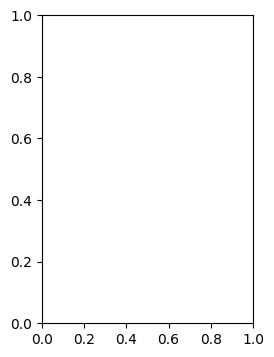

In [96]:
#1
plot_training_history(mlp_random, "MLP Random")
#2
plot_training_history(history_cnn_random, "CNN Random")
#3
plot_training_history(history_BiLstm_random , "BiLSTM Random")
#4
plot_training_history(history_CNN_LSTM_model_random , "CNN_LSTM Random")


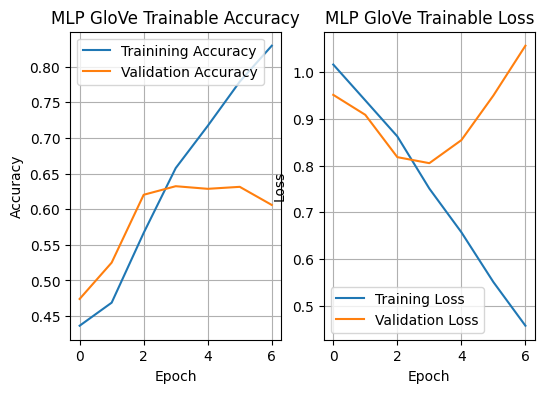

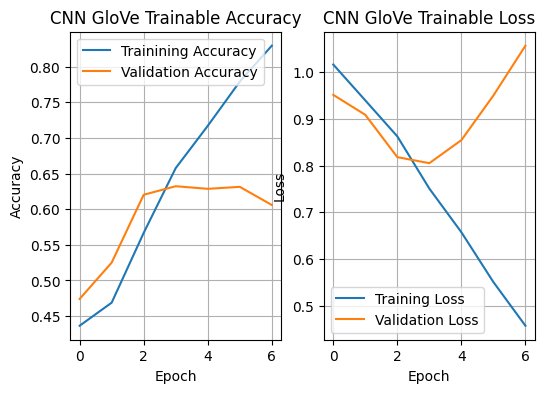

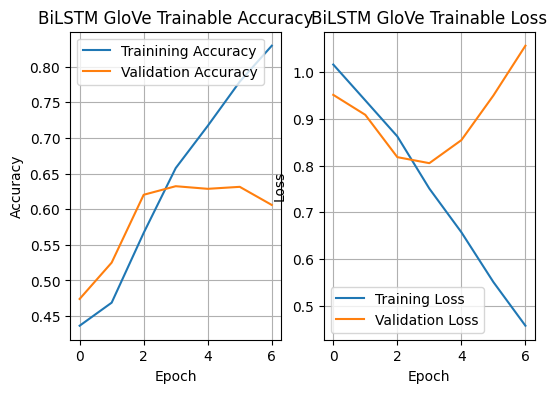

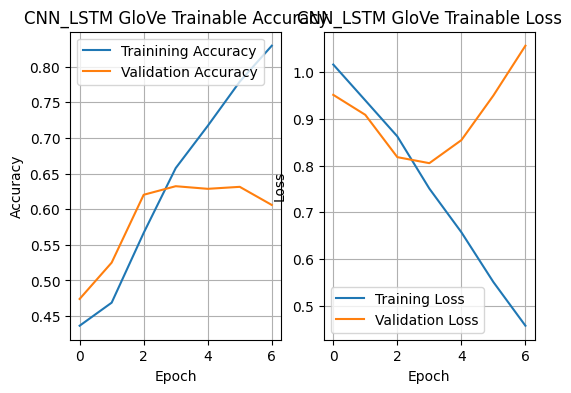

In [89]:
# MLP
plot_training_history(history, "MLP GloVe Trainable")
# CNN
plot_training_history(history, "CNN GloVe Trainable")

# BiLSTM
plot_training_history(history, "BiLSTM GloVe Trainable")

# CNN_LSTM
plot_training_history(history, "CNN_LSTM GloVe Trainable")


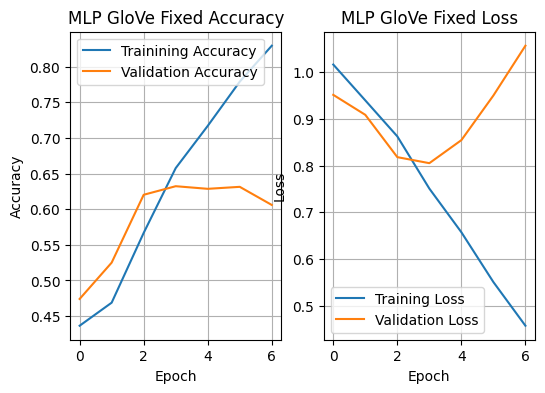

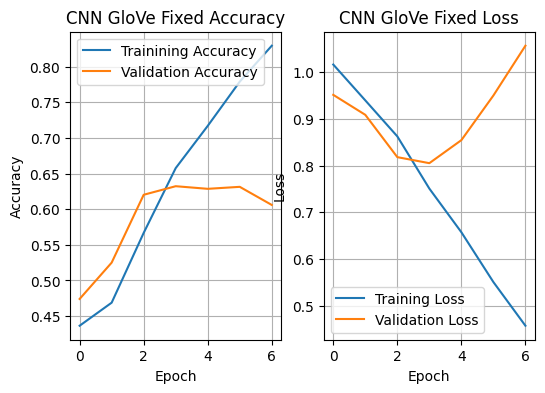

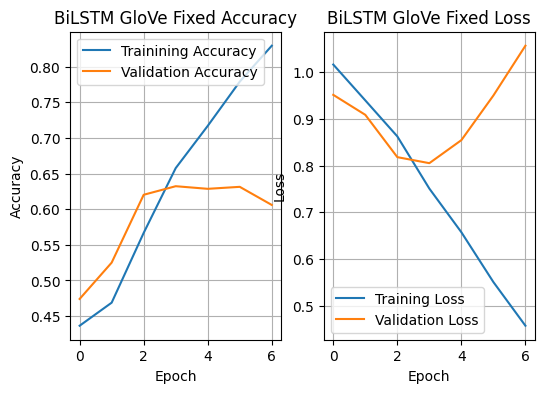

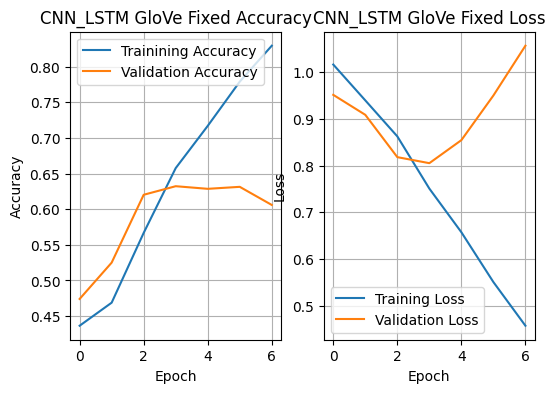

In [90]:
# MLP
plot_training_history(history, "MLP GloVe Fixed")

# CNN
plot_training_history(history, "CNN GloVe Fixed")

# BiLSTM
plot_training_history(history, "BiLSTM GloVe Fixed")

# CNN_LSTM
plot_training_history(history, "CNN_LSTM GloVe Fixed")


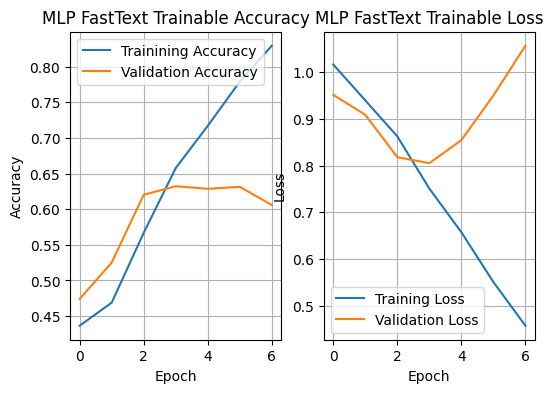

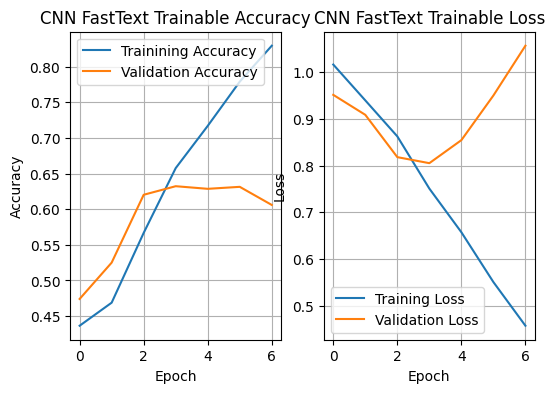

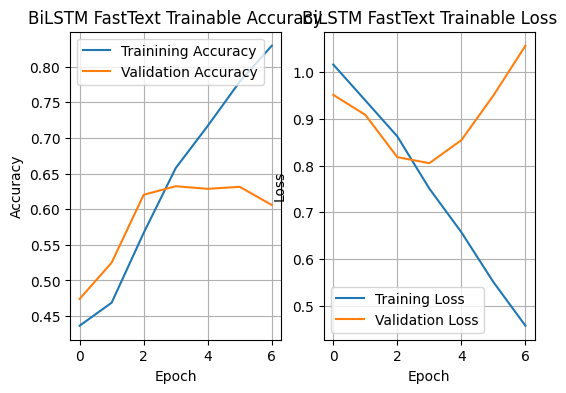

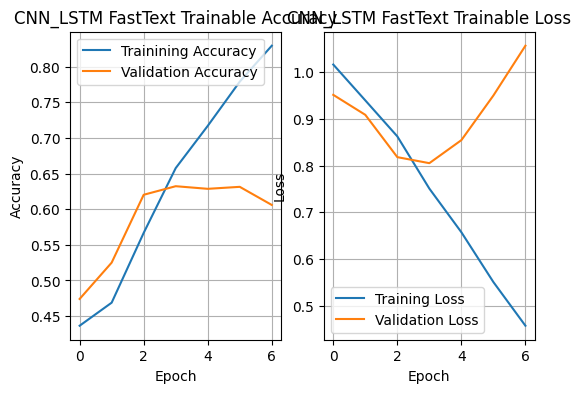

In [91]:
# MLP
plot_training_history(history, "MLP FastText Trainable")

# CNN
plot_training_history(history, "CNN FastText Trainable")

# BiLSTM
plot_training_history(history, "BiLSTM FastText Trainable")

# CNN_LSTM
plot_training_history(history, "CNN_LSTM FastText Trainable")


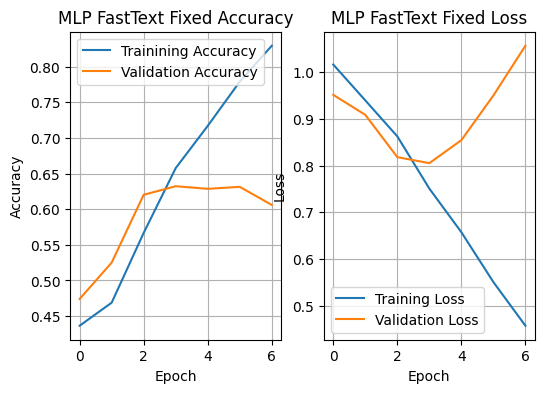

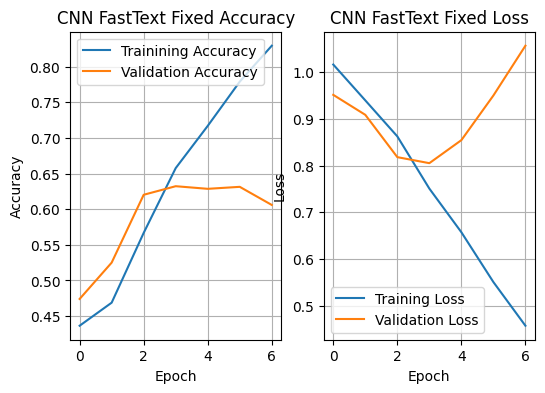

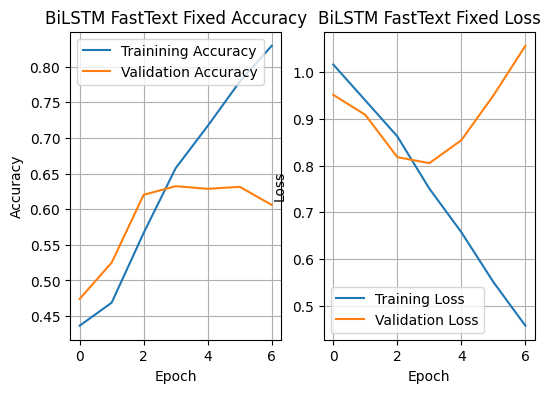

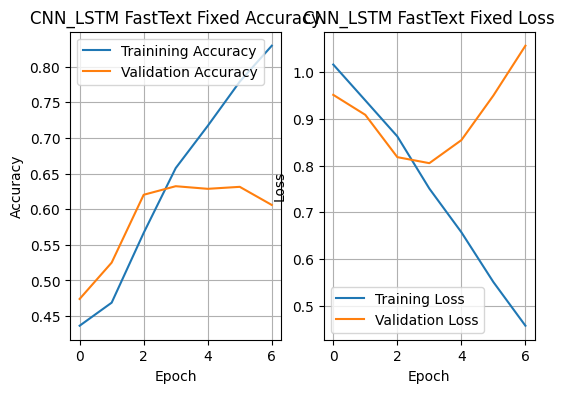

In [92]:
# MLP
plot_training_history(history, "MLP FastText Fixed")

# CNN

plot_training_history(history, "CNN FastText Fixed")

# BiLSTM

plot_training_history(history, "BiLSTM FastText Fixed")

# CNN_LSTM

plot_training_history(history, "CNN_LSTM FastText Fixed")


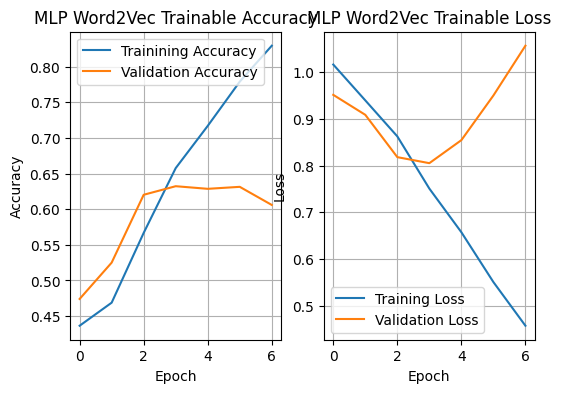

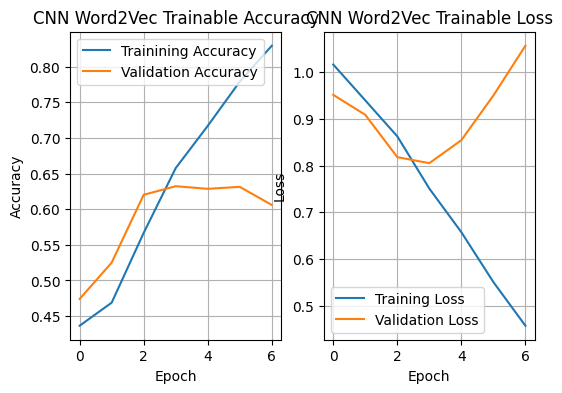

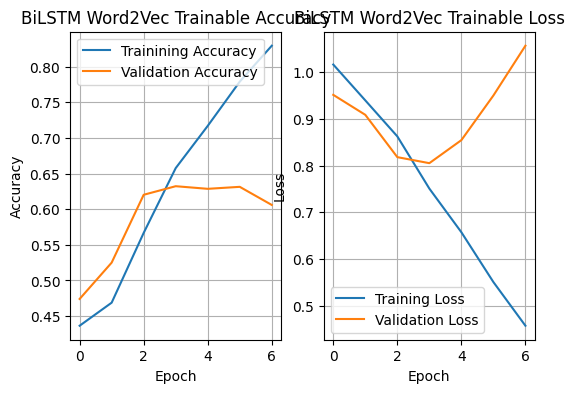

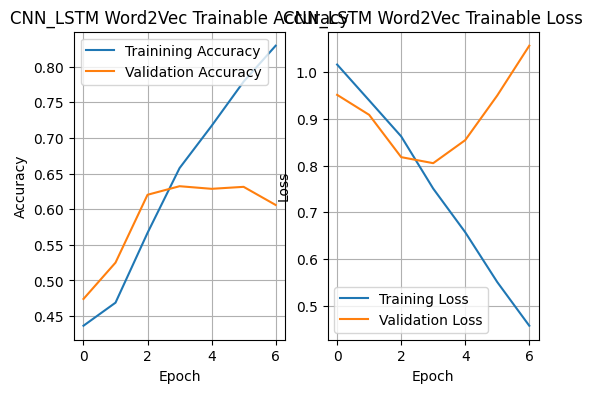

In [93]:
# MLP
plot_training_history(history, "MLP Word2Vec Trainable")

# CNN

plot_training_history(history, "CNN Word2Vec Trainable")

# BiLSTM

plot_training_history(history, "BiLSTM Word2Vec Trainable")
#CNNLSTM
plot_training_history(history, "CNN_LSTM Word2Vec Trainable")


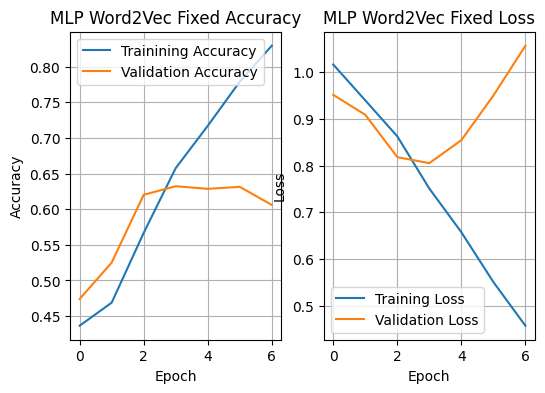

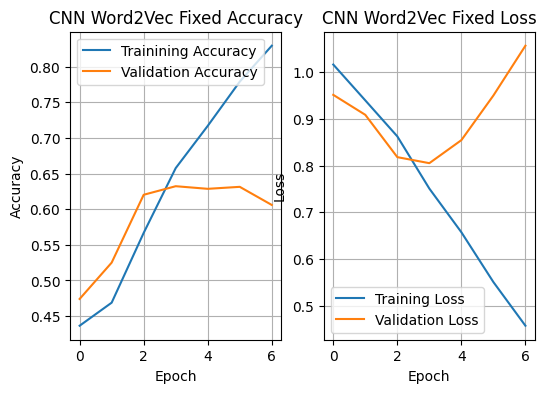

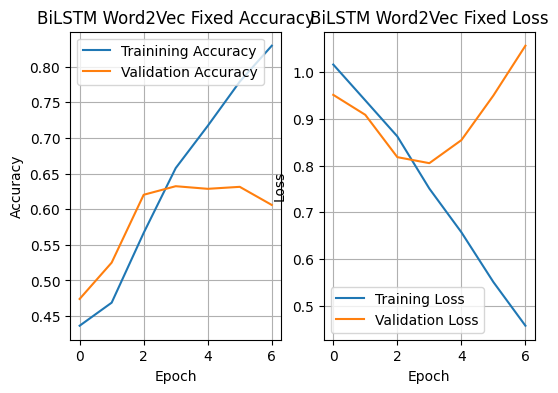

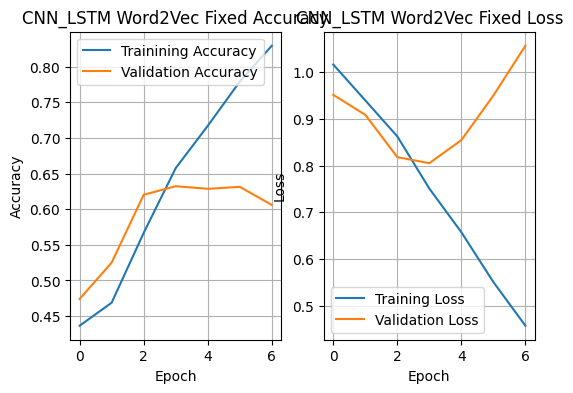

In [94]:
plot_training_history(history, "MLP Word2Vec Fixed")
plot_training_history(history, "CNN Word2Vec Fixed")
plot_training_history(history, "BiLSTM Word2Vec Fixed")
plot_training_history(history, "CNN_LSTM Word2Vec Fixed")

In [ ]:
plot_confusion(trained_model, model_name)

309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


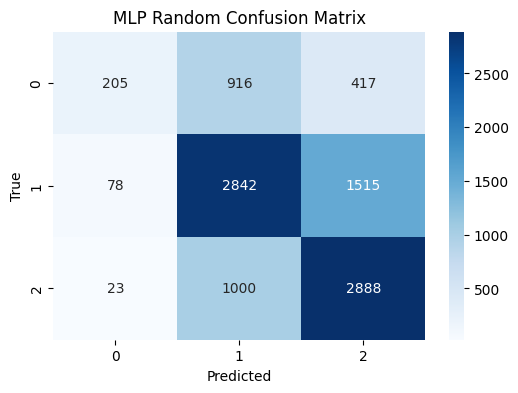

309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


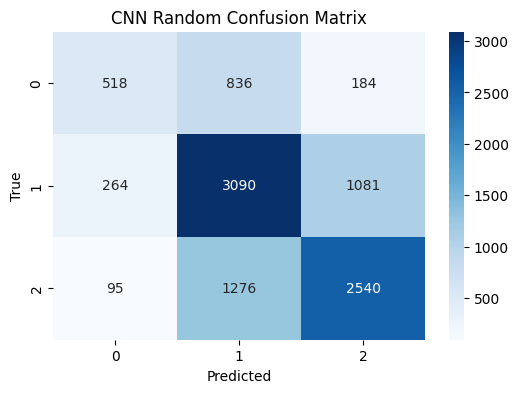

309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


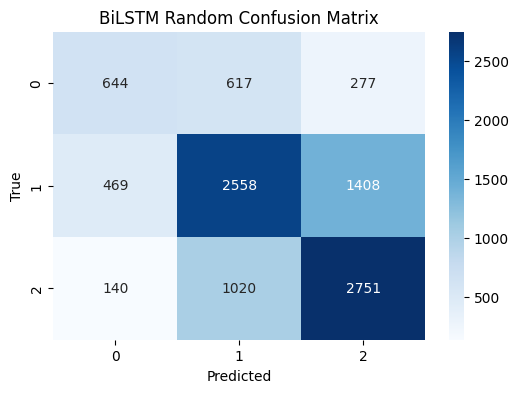

309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


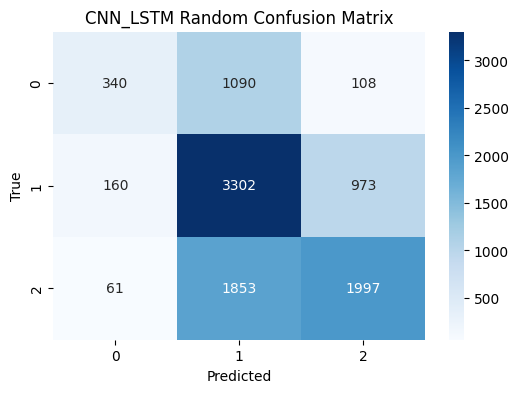

In [105]:
#1
plot_confusion(mlp_random, "MLP Random")
#2
plot_confusion(cnn_random, "CNN Random")
#3
plot_confusion(BiLstm_random , "BiLSTM Random")
#4
plot_confusion(CNN_LSTM_model_random , "CNN_LSTM Random")


309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


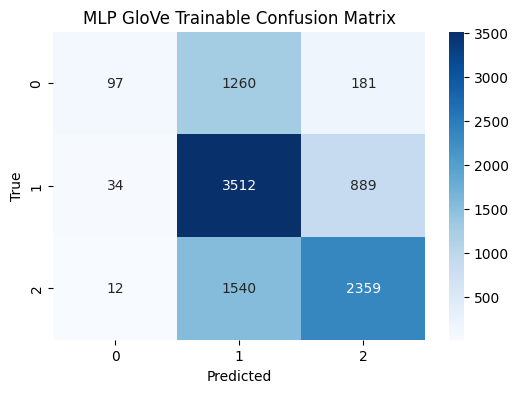

309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


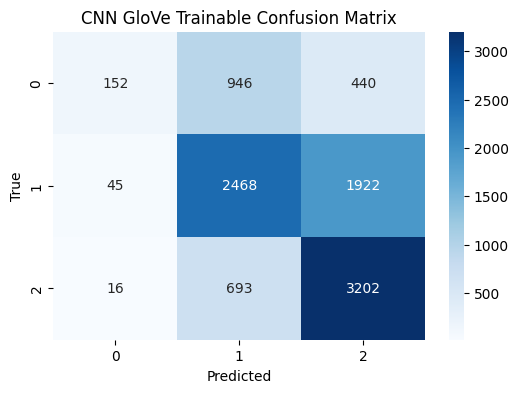

309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


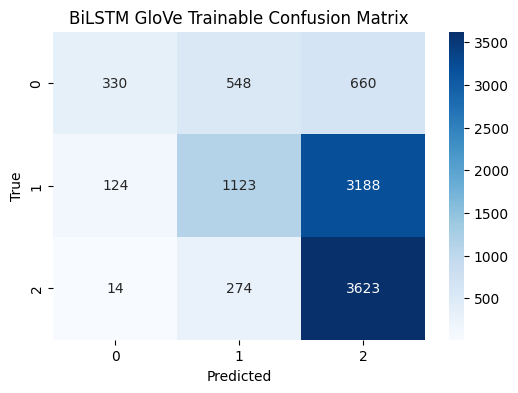

309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


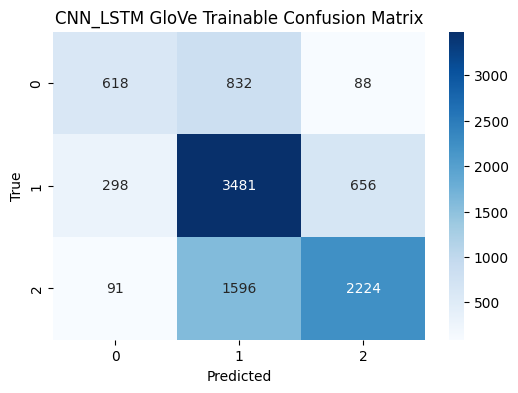

309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


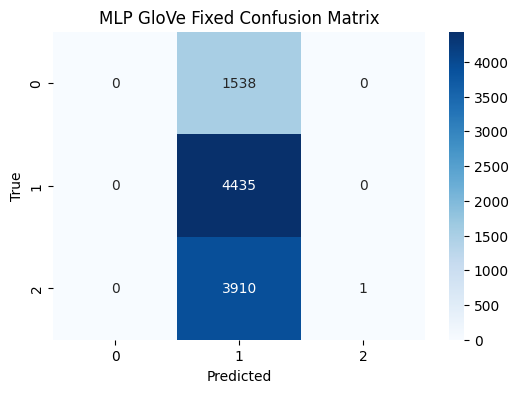

309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


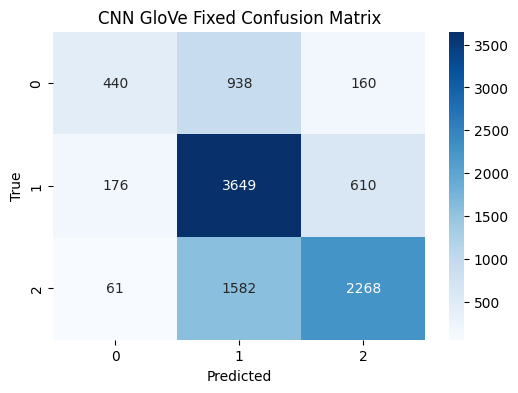

309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


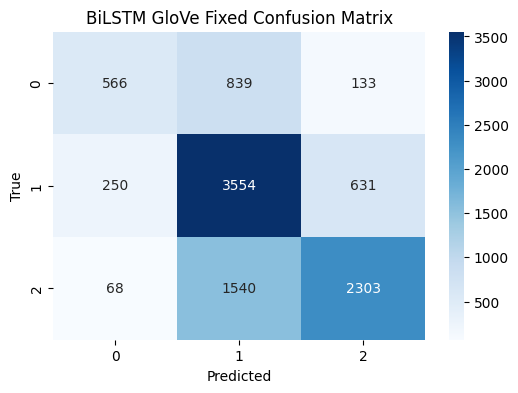

309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


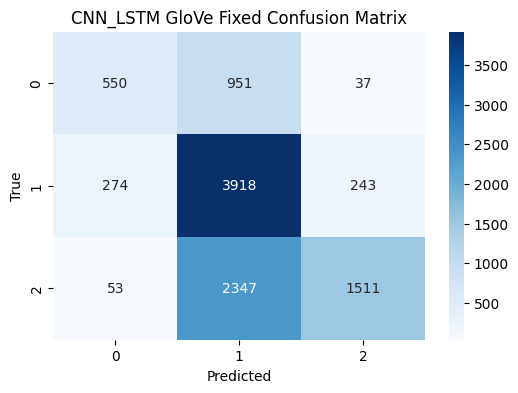

309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


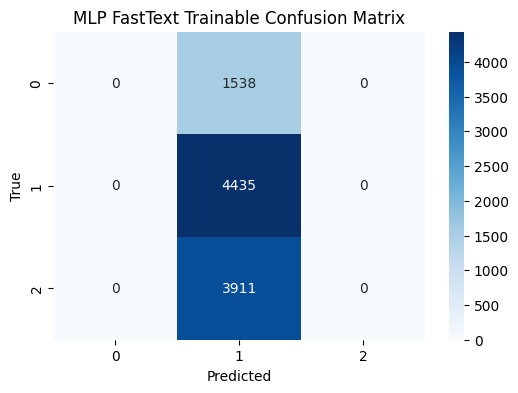

309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


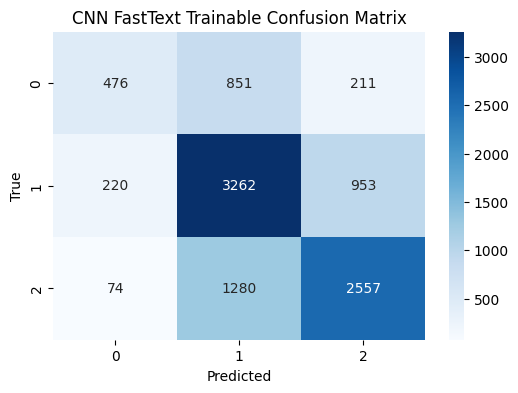

309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


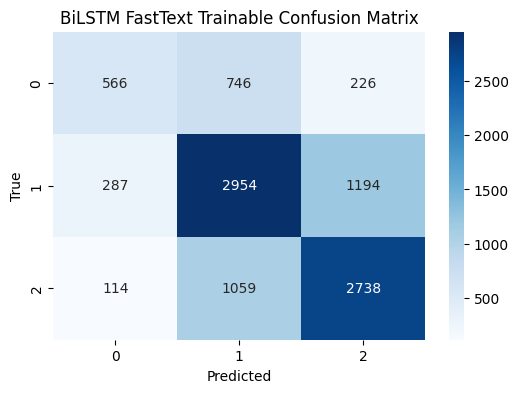

309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


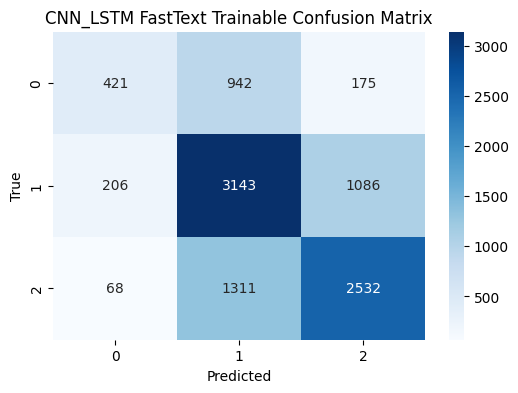

309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


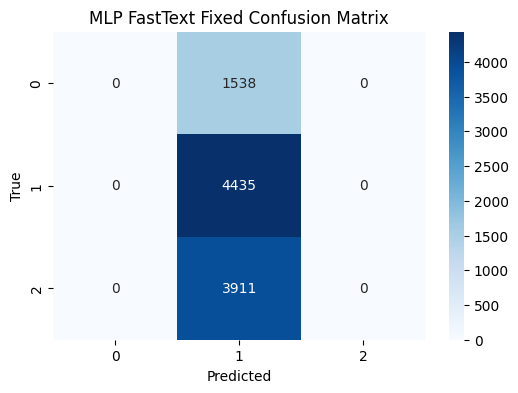

309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


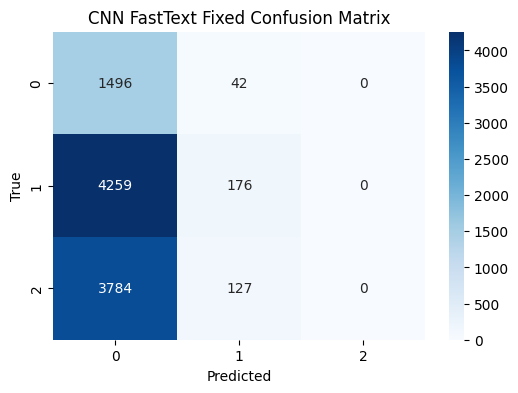

309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


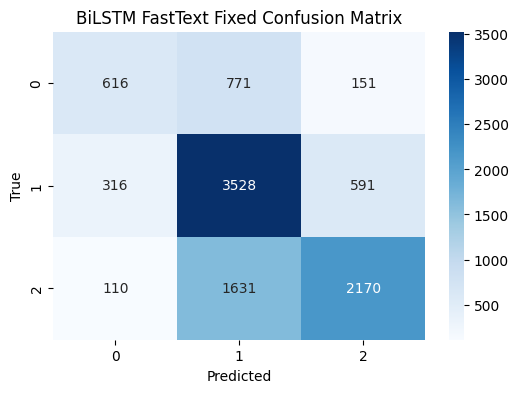

309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


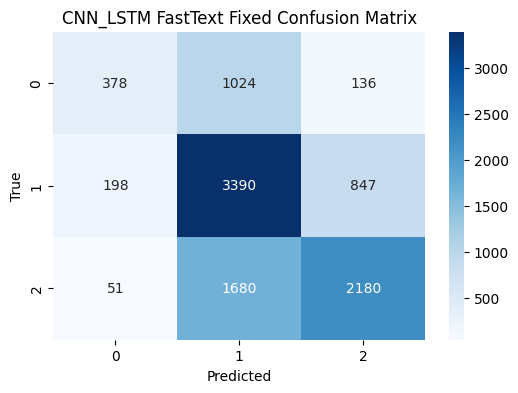

309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


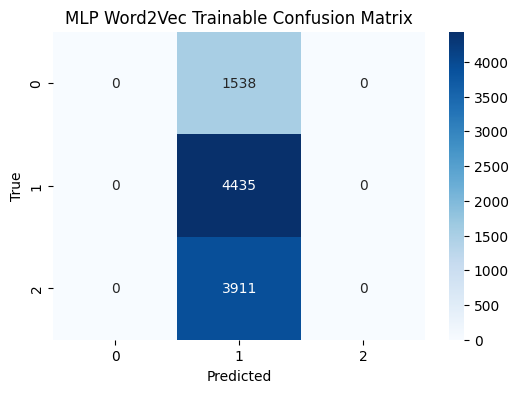

309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


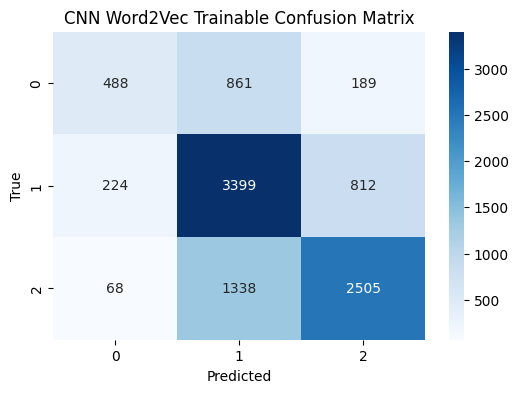

309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


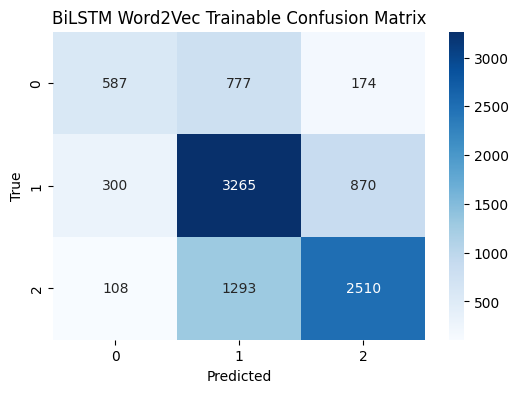

309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


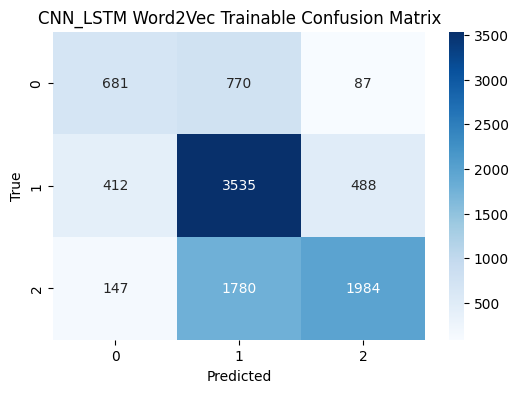

309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


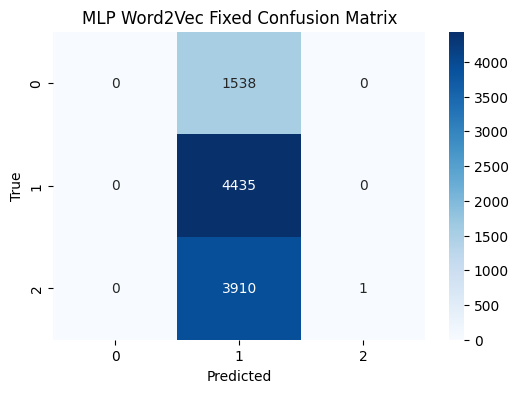

309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


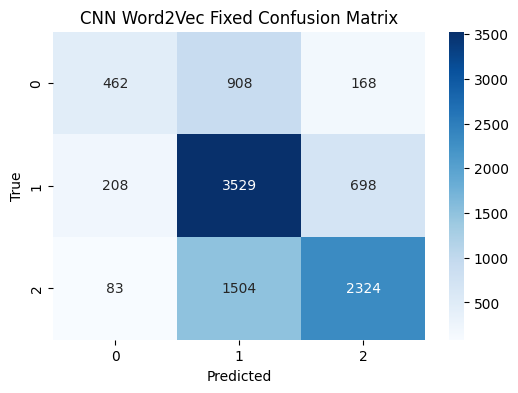

309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


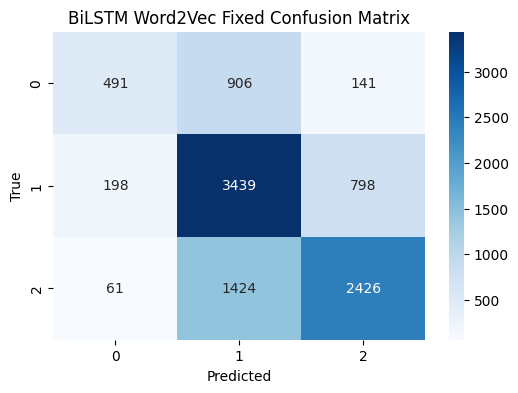

309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


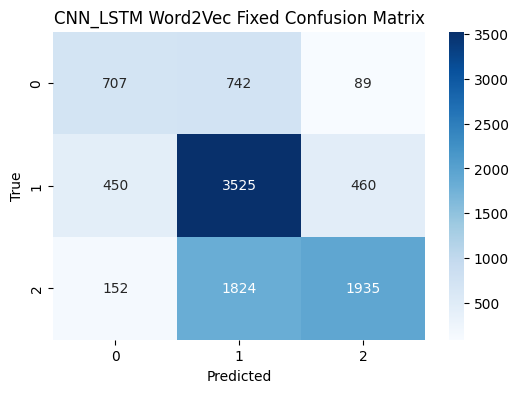

In [106]:
# MLP

plot_confusion(mlp_glove_trainable, model_name="MLP GloVe Trainable")

# CNN
plot_confusion(cnn_glove_trainable, model_name="CNN GloVe Trainable")

# BiLSTM
plot_confusion(BiLstm_glove_trainable, model_name="BiLSTM GloVe Trainable")

# CNN_LSTM
plot_confusion(CNN_LSTM_glove_trainable, model_name="CNN_LSTM GloVe Trainable")

# MLP
plot_confusion(mlp_glove_fixed, model_name="MLP GloVe Fixed")

# CNN
plot_confusion(cnn_glove_fixed, model_name="CNN GloVe Fixed")

# BiLSTM
plot_confusion(BiLstm_glove_fixed, model_name="BiLSTM GloVe Fixed")

# CNN_LSTM
plot_confusion(CNN_LSTM_glove_fixed, model_name="CNN_LSTM GloVe Fixed")

# MLP
plot_confusion(mlp_fasttext_trainable, model_name="MLP FastText Trainable")

# CNN
plot_confusion(cnn_fasttext_trainable, model_name="CNN FastText Trainable")

# BiLSTM
plot_confusion(BiLstm_fasttext_trainable, model_name="BiLSTM FastText Trainable")

# CNN_LSTM
plot_confusion(CNN_LSTM_fasttext_trainable, model_name="CNN_LSTM FastText Trainable")

plot_confusion(mlp_fasttext_fixed, model_name="MLP FastText Fixed")

# CNN
plot_confusion(cnn_fasttext_fixed, model_name="CNN FastText Fixed")

# BiLSTM
plot_confusion(BiLstm_fasttext_fixed, model_name="BiLSTM FastText Fixed")

# CNN_LSTM

plot_confusion(CNN_LSTM_fasttext_fixed, model_name="CNN_LSTM FastText Fixed")

# MLP
plot_confusion(mlp_word2vec_trainable, model_name="MLP Word2Vec Trainable")

# CNNe)
plot_confusion(cnn_word2vec_trainable, model_name="CNN Word2Vec Trainable")

# BiLSTM
plot_confusion(BiLstm_word2vec_trainable, model_name="BiLSTM Word2Vec Trainable")

# CNN_LSTM

plot_confusion(CNN_LSTM_word2vec_trainable, model_name="CNN_LSTM Word2Vec Trainable")

# MLP
plot_confusion(mlp_word2vec_fixed, model_name="MLP Word2Vec Fixed")

# CNN

plot_confusion(cnn_word2vec_fixed, model_name="CNN Word2Vec Fixed")

# BiLSTM
plot_confusion(BiLstm_word2vec_fixed, model_name="BiLSTM Word2Vec Fixed")

# CNN_LSTM
plot_confusion(CNN_LSTM_word2vec_fixed, model_name="CNN_LSTM Word2Vec Fixed")


